# Objective

This notebook aims to implement a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset. The process will involve:

1.  Loading and normalizing the CIFAR-10 dataset.
2.  Defining a CNN architecture with the following specifications:
    *   C1C2C3C4O architecture (No MaxPooling, but 3 3x3 layers with stride of 2 instead).
    *   Total Receptive Field (RF) must be more than 44.
    *   One layer must use Depthwise Separable Convolution.
    *   One layer must use Dilated Convolution.
    *   Use Global Average Pooling (GAP). Adding a Fully Connected (FC) layer after GAP to target the number of classes is optional.
3.  Applying data augmentation using the `albumentations` library with:
    *   Horizontal flip.
    *   ShiftScaleRotate.
    *   CoarseDropout (max_holes = 1, max_height=16px, max_width=1, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None).
4.  Training the CNN on the training data to achieve at least 85% accuracy. The total number of parameters must be less than 200k.
5.  Evaluating the CNN's performance on the test data.
6.  Ensuring code modularity.
7.  Uploading the solution to GitHub (S7-Assignment Solution).


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

## Load Dataset

This section handles the loading of the CIFAR-10 dataset for both training and testing. After loading, we will perform some basic observations on the dataset, such as printing the total number of examples and the distinct labels present.


In [9]:
# Load CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True
)

# Load CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True
)

### Quick Stats

In [14]:
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
# Print dataset statistics
print(f"Total number of training examples: {len(trainset)}")
print(f"Total number of test examples: {len(testset)}")
print(f"Total number of examples (train + test): {len(trainset) + len(testset)}")
# Get distinct labels from the concatenated dataset
all_labels_numeric = sorted(list(set(trainset.targets + testset.targets)))

print(f"Distinct labels in the dataset (numeric): {all_labels_numeric}")
print(f"Distinct labels in the dataset (description): {[classes[i] for i in all_labels_numeric]}")

# Get a sample image to determine its properties
sample_image, _ = trainset[0]
print(f"Input image size: {sample_image.size}")
print(f"Number of channels: {len(sample_image.getbands())}")


Total number of training examples: 50000
Total number of test examples: 10000
Total number of examples (train + test): 60000
Distinct labels in the dataset (numeric): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Distinct labels in the dataset (description): ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Input image size: (32, 32)
Number of channels: 3


In [15]:
import collections

# Check image sizes in trainset
train_image_sizes = collections.defaultdict(int)
for i in range(len(trainset)):
    image, _ = trainset[i]
    train_image_sizes[image.size] += 1

print("Trainset Image Sizes:")
for size, count in train_image_sizes.items():
    print(f"  {size}: {count} images")

# Check image sizes in testset
test_image_sizes = collections.defaultdict(int)
for i in range(len(testset)):
    image, _ = testset[i]
    test_image_sizes[image.size] += 1

print("\nTestset Image Sizes:")
for size, count in test_image_sizes.items():
    print(f"  {size}: {count} images")


Trainset Image Sizes:
  (32, 32): 50000 images

Testset Image Sizes:
  (32, 32): 10000 images


In [29]:
from collections import Counter

# Count labels in the training set
train_label_counts = Counter(trainset.targets)
print("Training set label distribution:")
for label_idx, count in sorted(train_label_counts.items()):
    print(f"  {classes[label_idx]}: {count} images")

# Count labels in the test set
test_label_counts = Counter(testset.targets)
print("\nTest set label distribution:")
for label_idx, count in sorted(test_label_counts.items()):
    print(f"  {classes[label_idx]}: {count} images")

# Check for even distribution
num_classes = len(classes)
expected_train_per_class = len(trainset) / num_classes
expected_test_per_class = len(testset) / num_classes

print(f"\nExpected training images per class: {expected_train_per_class:.0f}")
print(f"Expected test images per class: {expected_test_per_class:.0f}")

is_train_evenly_distributed = all(count == expected_train_per_class for count in train_label_counts.values())
is_test_evenly_distributed = all(count == expected_test_per_class for count in test_label_counts.values())

print(f"Is training set evenly distributed? {is_train_evenly_distributed}")
print(f"Is test set evenly distributed? {is_test_evenly_distributed}")


Training set label distribution:
  plane: 5000 images
  car: 5000 images
  bird: 5000 images
  cat: 5000 images
  deer: 5000 images
  dog: 5000 images
  frog: 5000 images
  horse: 5000 images
  ship: 5000 images
  truck: 5000 images

Test set label distribution:
  plane: 1000 images
  car: 1000 images
  bird: 1000 images
  cat: 1000 images
  deer: 1000 images
  dog: 1000 images
  frog: 1000 images
  horse: 1000 images
  ship: 1000 images
  truck: 1000 images

Expected training images per class: 5000
Expected test images per class: 1000
Is training set evenly distributed? True
Is test set evenly distributed? True


### View Some Images

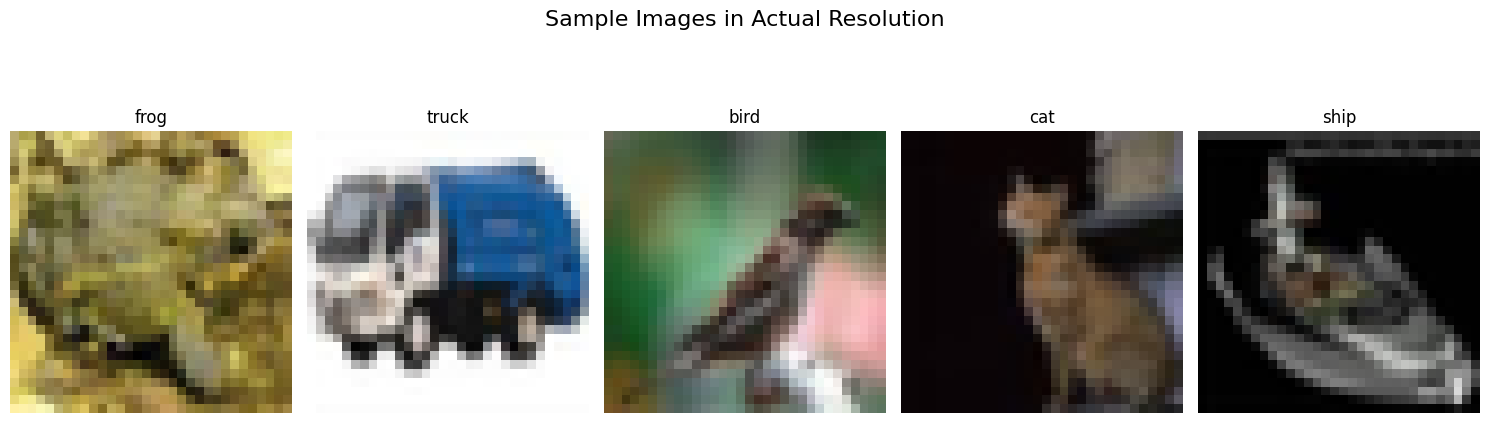

In [21]:
import random

# Display a few actual resolution images (5 different classes)
num_images_to_show = 5
selected_classes = random.sample(range(len(classes)), num_images_to_show)

plt.figure(figsize=(15, 5))
for i, class_idx in enumerate(selected_classes):
    # Find an image for the current class
    class_indices = [j for j, label in enumerate(trainset.targets) if label == class_idx]
    img_idx = random.choice(class_indices)
    image, _ = trainset[img_idx]
    
    ax = plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(image)
    plt.title(classes[class_idx])
    plt.axis('off')
plt.suptitle('Sample Images in Actual Resolution', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Are Images Blurry - Laplacian Variance

Average sharpness (Laplacian Variance) for 200 sample images: 2330.68
Min sharpness: 295.56
Max sharpness: 8515.48


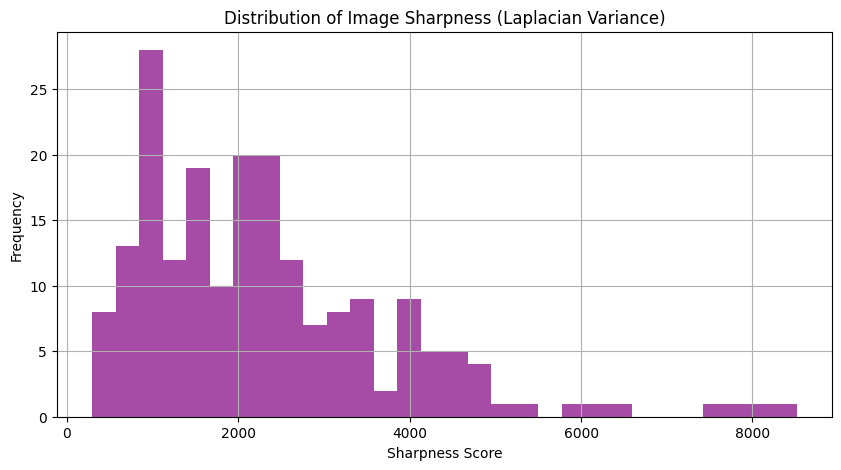

In [23]:
import cv2
from PIL import Image

# Function to calculate Laplacian variance (sharpness)
def calculate_laplacian_variance(image):
    # Convert PIL Image to NumPy array
    img_np = np.array(image)
    # Convert to grayscale
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    # Compute the Laplacian and then return the variance
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Randomly select 200 images from the training set
num_samples = 200
random_indices = random.sample(range(len(trainset)), num_samples)

sharpness_scores = []
for idx in random_indices:
    image, _ = trainset[idx]
    sharpness = calculate_laplacian_variance(image)
    sharpness_scores.append(sharpness)

# Print some statistics about the sharpness scores
print(f"Average sharpness (Laplacian Variance) for {num_samples} sample images: {np.mean(sharpness_scores):.2f}")
print(f"Min sharpness: {np.min(sharpness_scores):.2f}")
print(f"Max sharpness: {np.max(sharpness_scores):.2f}")

# Optionally, visualize the distribution of sharpness scores
plt.figure(figsize=(10, 5))
plt.hist(sharpness_scores, bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Image Sharpness (Laplacian Variance)')
plt.xlabel('Sharpness Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


#### Laplacian Variance
The Laplacian variance is a simple way to check if an image is sharp or blurry. Here’s an easy explanation and step-by-step guide for setting a threshold in your scenario, especially for CIFAR images.

**Intuitive Understanding**
Imagine you have a coloring book. If you color very carefully, the lines (edges) are easy to see and the picture looks clear. But if you accidentally smudge the picture, the lines are hard to find and the picture looks blurry.

- The Laplacian is a math tool that looks for all those lines (edges) in a picture.
- After finding the lines, the Laplacian variance checks how “busy” those lines are. More lines and big changes mean a big number (sharp), and very few changes mean a small number (blurry).
- Computers do this by making a new image showing only the edges, then seeing how different the edge values are from each other using a math step called “variance.” If the variance is high, the image is clear. If it’s low, it’s blurry.

**How Laplacian Variance Is Computed**
- Turn your image gray so there is only one value per pixel.
- Use the Laplacian filter to make an “edges-only” picture.
- Take all those edge values and see how much they differ using variance:
- If all pixels look about the same (not many edges), the variance is low (blurry).
- If there are big changes between pixels (lots of edges), the variance is high (sharp).



Calculating sharpness for all training images...
Training sharpness calculation complete.
Calculating sharpness for all test images...
Test sharpness calculation complete.


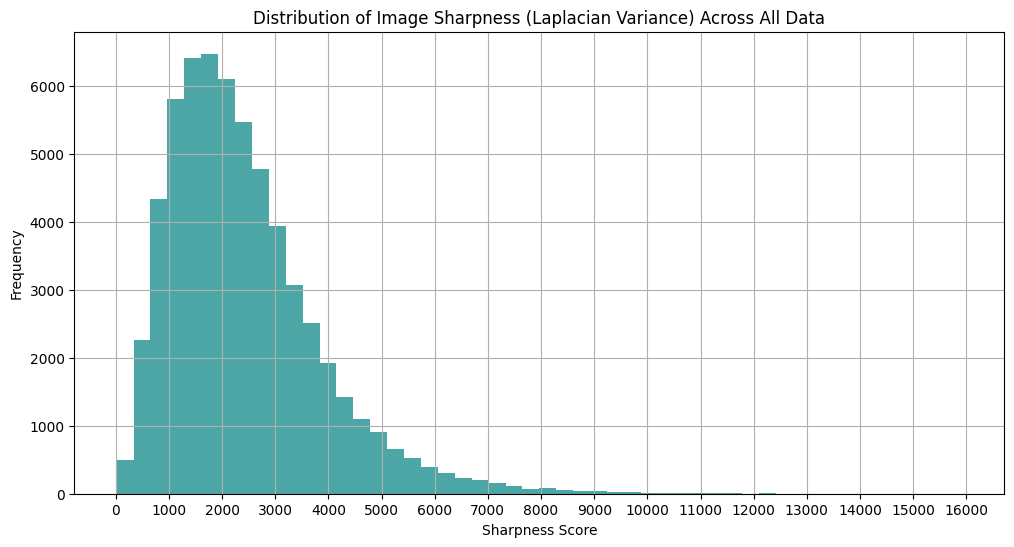


Overall sharpness (Laplacian Variance) for all images (train + test): 2415.33
Overall Min sharpness: 18.34
Overall Max sharpness: 15920.40


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming calculate_laplacian_variance is defined in a previous cell or globally accessible
# If not, you might need to re-define it here or ensure previous cells are run.
# For this task, I will re-include the function for self-containment.

def calculate_laplacian_variance(image):
    # Convert PIL Image to NumPy array
    img_np = np.array(image)
    # Convert to grayscale
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    # Compute the Laplacian and then return the variance
    return cv2.Laplacian(gray, cv2.CV_64F).var()

print("Calculating sharpness for all training images...")
train_sharpness_scores = []
for i in range(len(trainset)):
    image, _ = trainset[i]
    sharpness = calculate_laplacian_variance(image)
    train_sharpness_scores.append(sharpness)
print("Training sharpness calculation complete.")

print("Calculating sharpness for all test images...")
test_sharpness_scores = []
for i in range(len(testset)):
    image, _ = testset[i]
    sharpness = calculate_laplacian_variance(image)
    test_sharpness_scores.append(sharpness)
print("Test sharpness calculation complete.")

all_sharpness_scores = train_sharpness_scores + test_sharpness_scores

plt.figure(figsize=(12, 6))
plt.hist(all_sharpness_scores, bins=50, color='teal', alpha=0.7)
plt.title('Distribution of Image Sharpness (Laplacian Variance) Across All Data')
plt.xlabel('Sharpness Score')
plt.ylabel('Frequency')
plt.grid(True)

# Set x-axis ticks at intervals of 1000
max_sharpness = int(np.max(all_sharpness_scores))
plt.xticks(np.arange(0, max_sharpness + 1000, 1000))

plt.show()

print(f"\nOverall sharpness (Laplacian Variance) for all images (train + test): {np.mean(all_sharpness_scores):.2f}")
print(f"Overall Min sharpness: {np.min(all_sharpness_scores):.2f}")
print(f"Overall Max sharpness: {np.max(all_sharpness_scores):.2f}")


Calculating sharpness for 1000 images...
Sharpness calculation complete.


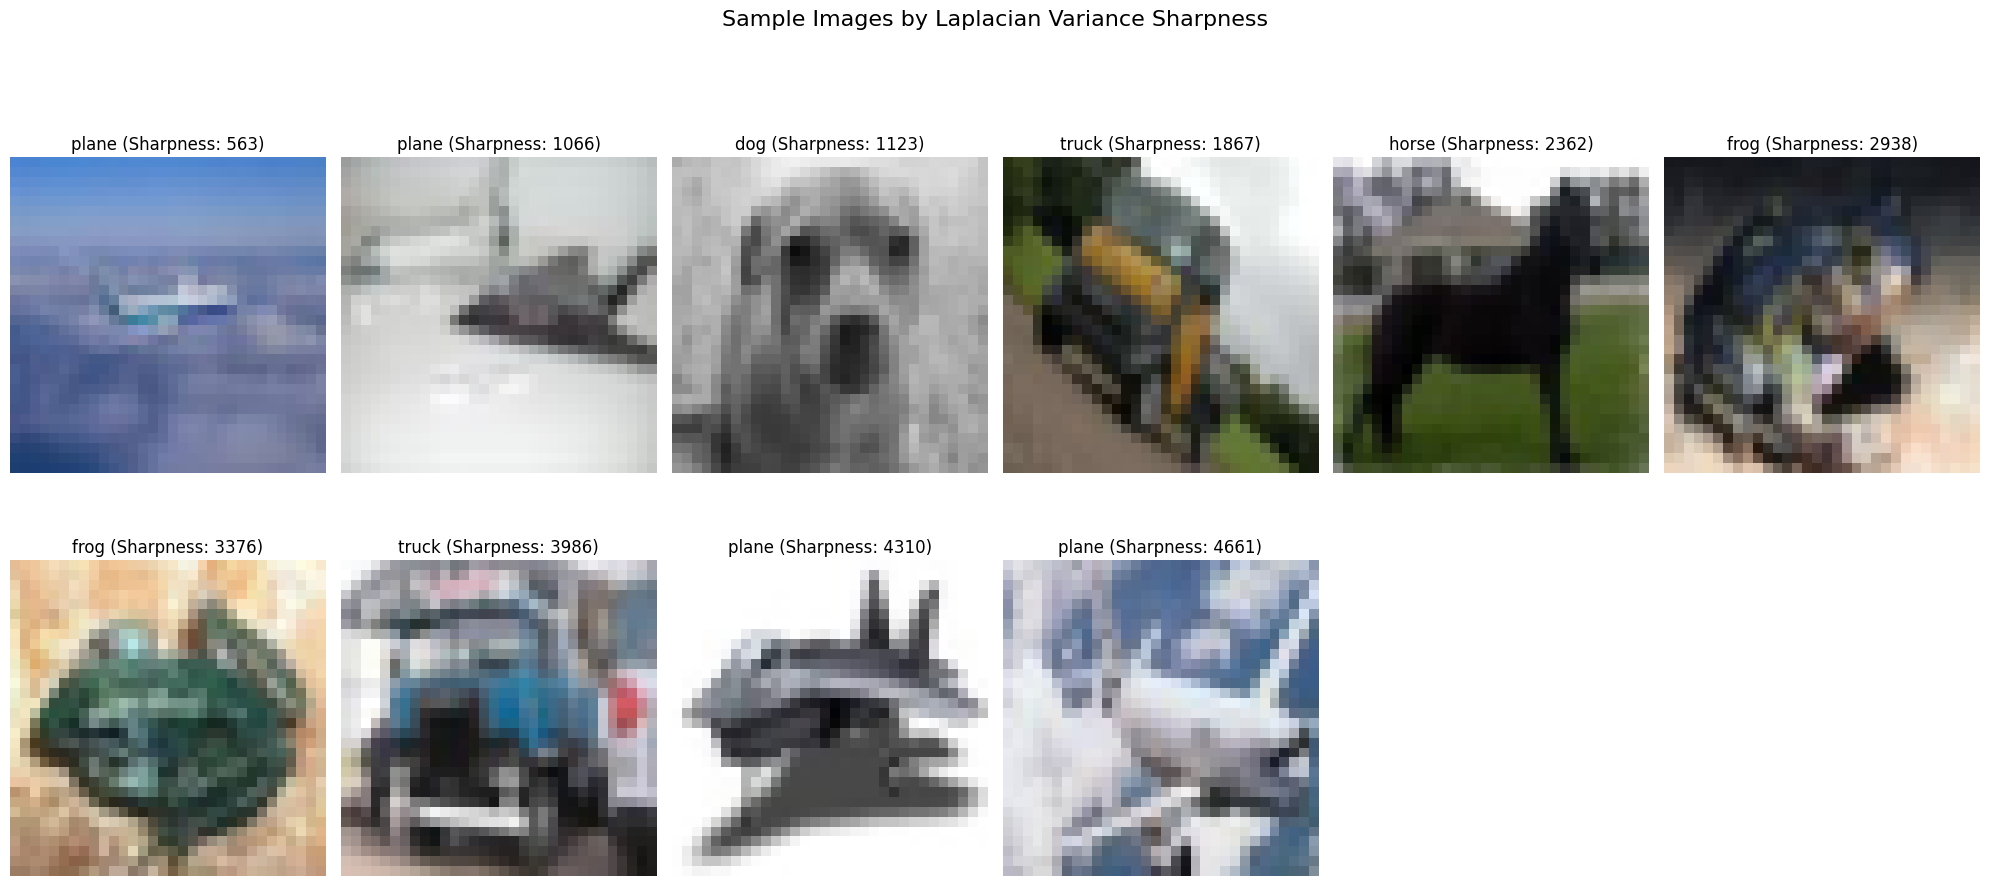

In [26]:
from collections import defaultdict

# Calculate sharpness for a larger sample or the entire dataset
# For demonstration, let's calculate for a larger sample, say 1000 images.
# In a real scenario, you might want to calculate for all images if performance allows.

num_full_samples = 1000  # Or len(trainset) for all images
all_sharpness_data = [] # Store (sharpness, image, class_label) tuples

# To avoid recalculating if already done for a large enough sample
# For simplicity, we'll re-calculate here.

print(f"Calculating sharpness for {num_full_samples} images...")
for i in range(num_full_samples):
    idx = random.randrange(len(trainset))
    image, label = trainset[idx]
    sharpness = calculate_laplacian_variance(image)
    all_sharpness_data.append((sharpness, image, classes[label]))
print("Sharpness calculation complete.")

# Define sharpness ranges and collect one image for each range
sharpness_ranges = range(100, 5001, 500)
selected_images_by_sharpness = {}

for sharpness_val, image, class_label in all_sharpness_data:
    for r_start in sharpness_ranges:
        r_end = r_start + 500
        if r_start <= sharpness_val < r_end:
            if r_start not in selected_images_by_sharpness:
                selected_images_by_sharpness[r_start] = (image, sharpness_val, class_label)
            break

# Display the selected images
plt.figure(figsize=(20, 10))
plot_idx = 1

# Sort the keys to display in order
for r_start in sorted(selected_images_by_sharpness.keys()):
    image, sharpness_val, class_label = selected_images_by_sharpness[r_start]
    ax = plt.subplot(2, len(sharpness_ranges) // 2 + 1, plot_idx) # Adjust subplot grid as needed
    plt.imshow(image)
    plt.title(f'{class_label} (Sharpness: {sharpness_val:.0f})')
    plt.axis('off')
    plot_idx += 1

plt.suptitle('Sample Images by Laplacian Variance Sharpness', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#### Link to Laplacian Artefact
Here is a link for a basic intuition behind Laplacian Varaince - [Link](https://claude.ai/public/artifacts/24097cd1-629c-44e2-a62a-004dd4a91995)

#### Before - After (Sharpening Kernel)

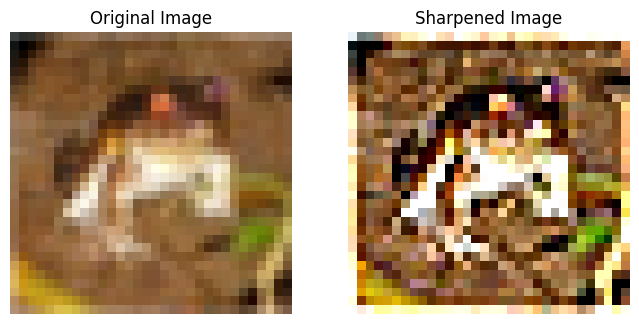

In [28]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define sharpening function
def sharpen_image(img_tensor):
    kernel = torch.tensor([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], dtype=torch.float32)
    kernel = kernel.view(1, 1, 3, 3)
    kernel = kernel.repeat(3, 1, 1, 1)
    img_tensor = img_tensor.unsqueeze(0) # Add batch dimension
    sharp_img_tensor = F.conv2d(img_tensor, kernel, padding=1, groups=3)
    # Clamp pixel values to [0,1]
    sharp_img_tensor = torch.clamp(sharp_img_tensor, 0, 1)
    return sharp_img_tensor.squeeze(0) # Remove batch dimension

# Get a sample CIFAR-10 image (PIL Image)
raw_img, label = trainset[0]  # pick first image

# Convert PIL Image to PyTorch Tensor
transformer = transforms.ToTensor()
img_tensor = transformer(raw_img)

# Sharpen the image
sharp_img_tensor = sharpen_image(img_tensor)

# Convert tensors to numpy for displaying
img_np = img_tensor.permute(1,2,0).numpy()
sharp_img_np = sharp_img_tensor.permute(1,2,0).detach().numpy()

# Display before and after images
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(sharp_img_np)
plt.title('Sharpened Image')
plt.axis('off')

plt.show()


### See Image Brightness

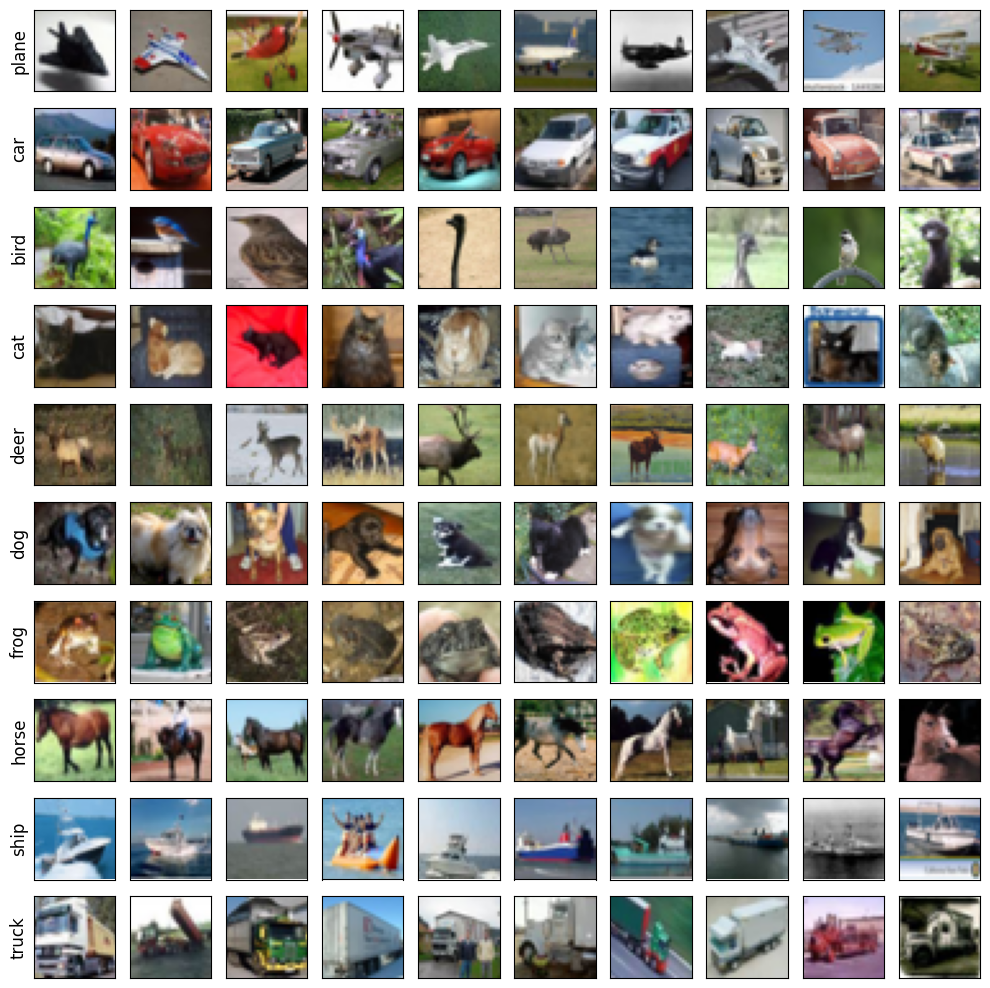

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show 10 thumbnails per class
def show_class_thumbnails(dataset, classes, num_thumbnails_per_class=10):
    fig = plt.figure(figsize=(num_thumbnails_per_class, len(classes)))
    for i, class_name in enumerate(classes):
        class_indices = [j for j, label in enumerate(dataset.targets) if label == i]
        for k in range(num_thumbnails_per_class):
            ax = fig.add_subplot(len(classes), num_thumbnails_per_class, i * num_thumbnails_per_class + k + 1, xticks=[], yticks=[])
            img, label = dataset[class_indices[k]]
            ax.imshow(img)
            if k == 0:
                ax.set_ylabel(class_name, rotation=90, size='large')
    plt.tight_layout()
    plt.show()

# Show thumbnails for training set
show_class_thumbnails(trainset, classes)


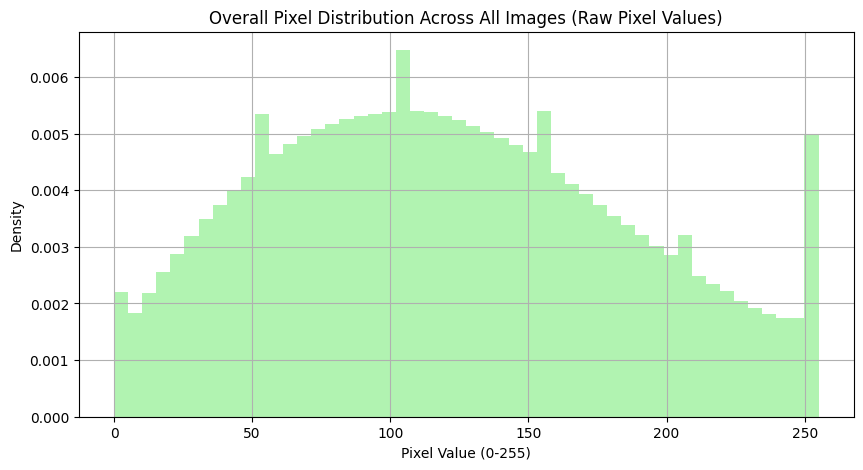

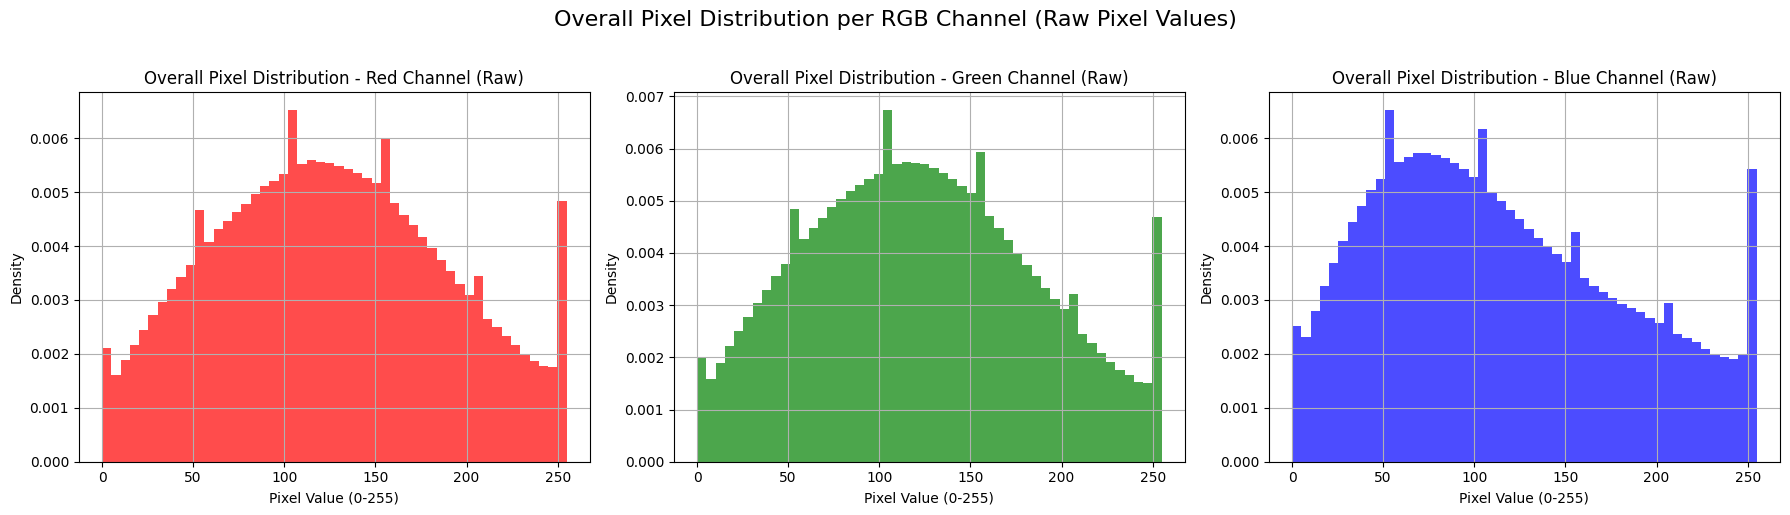

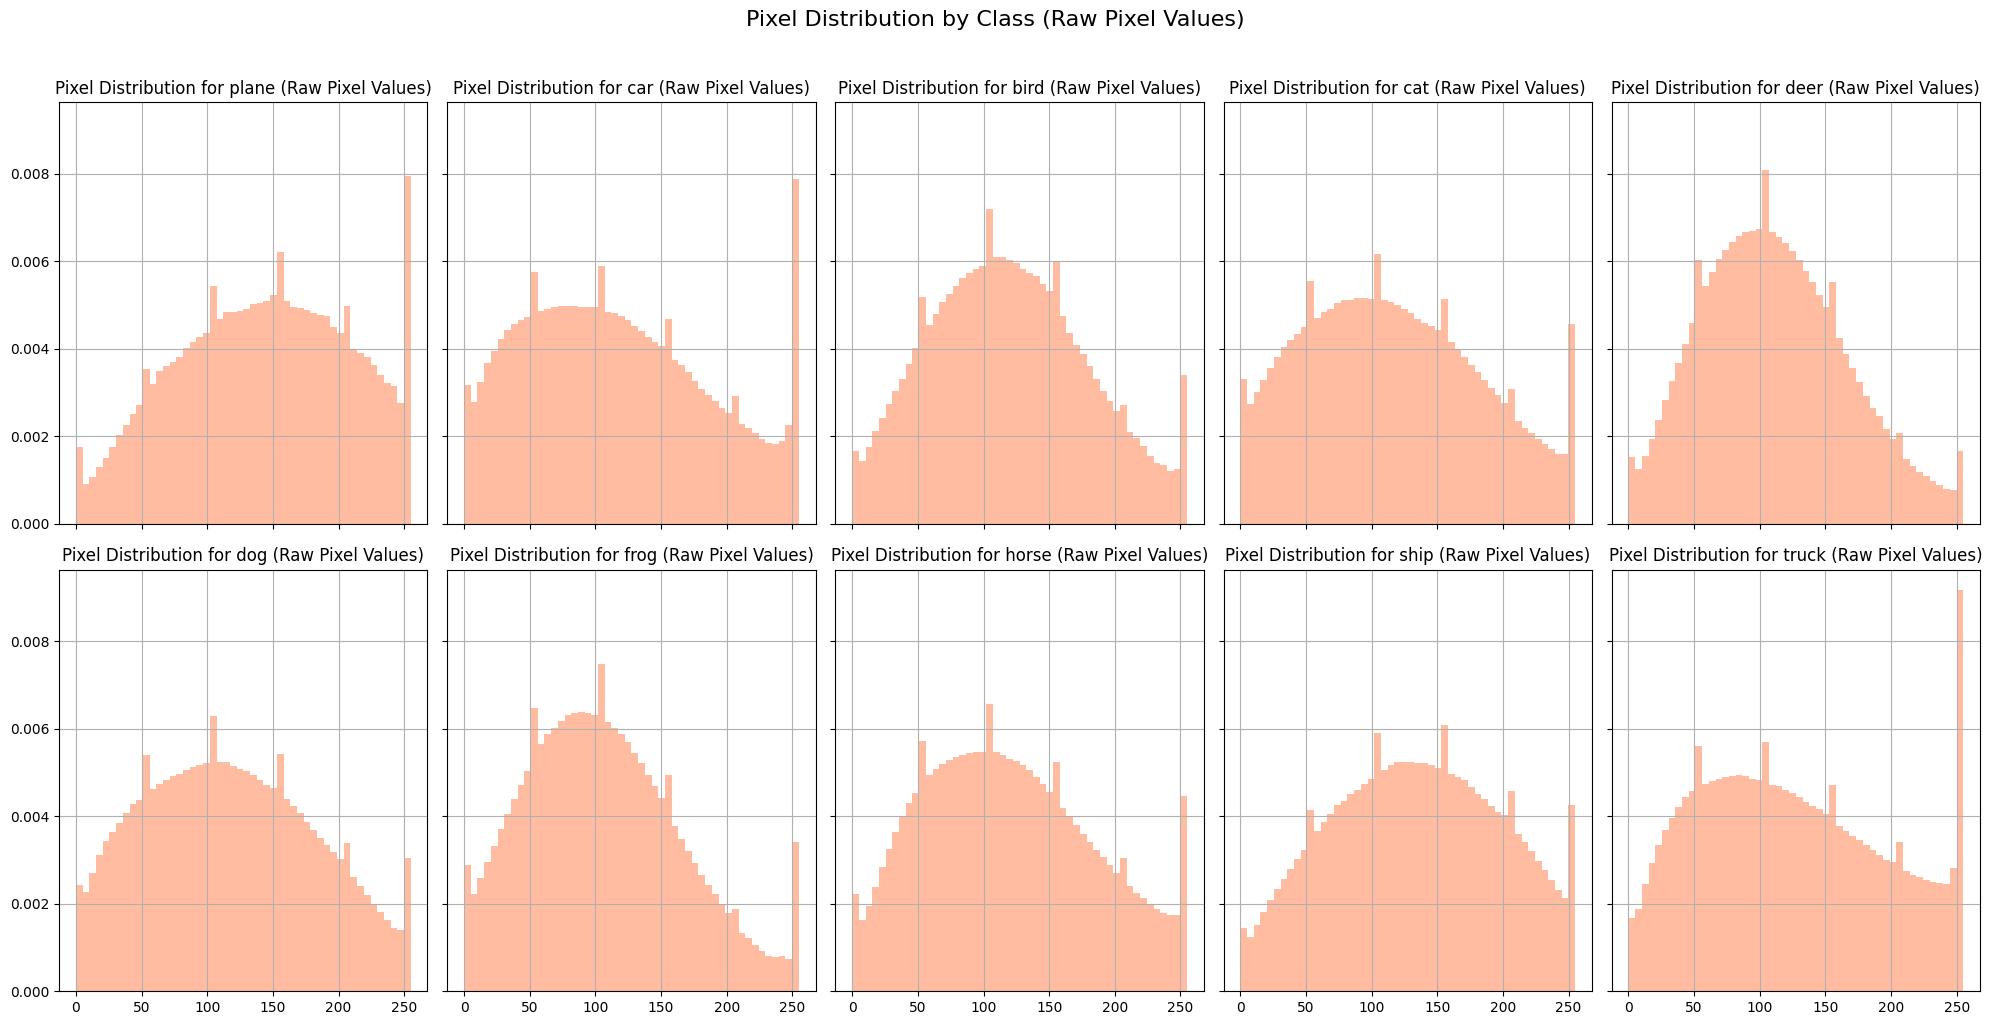

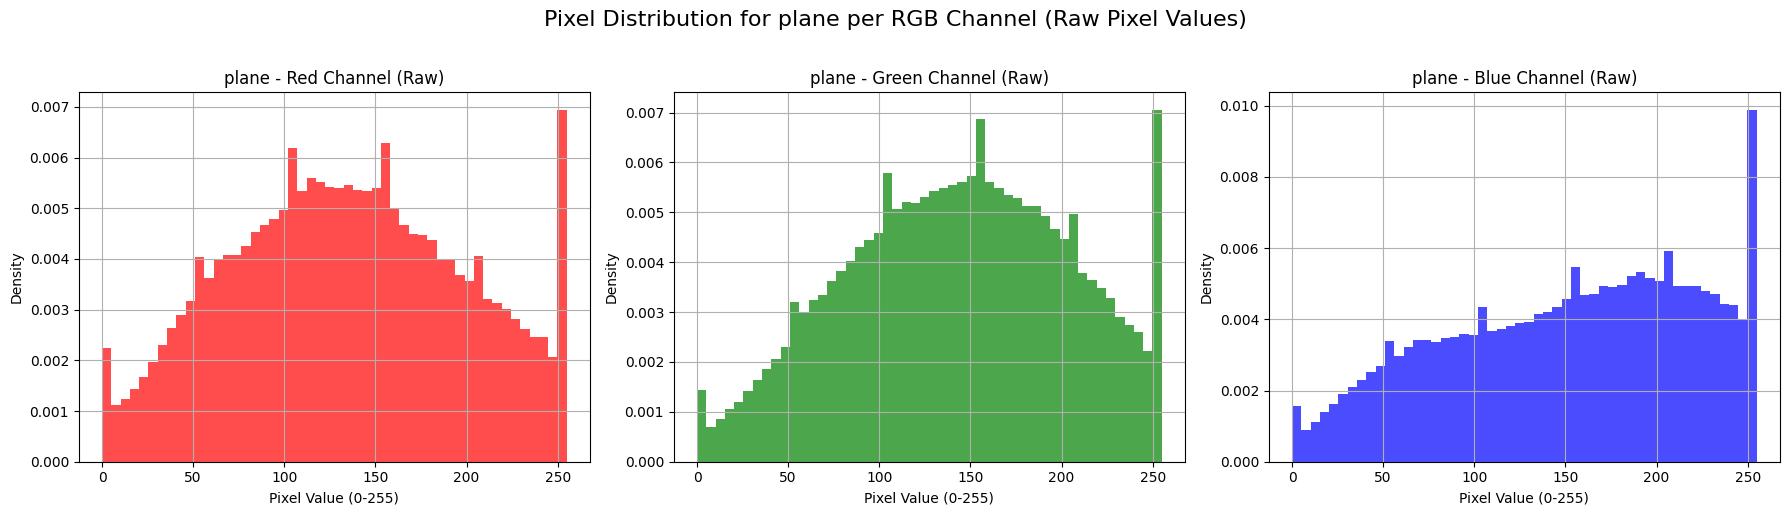

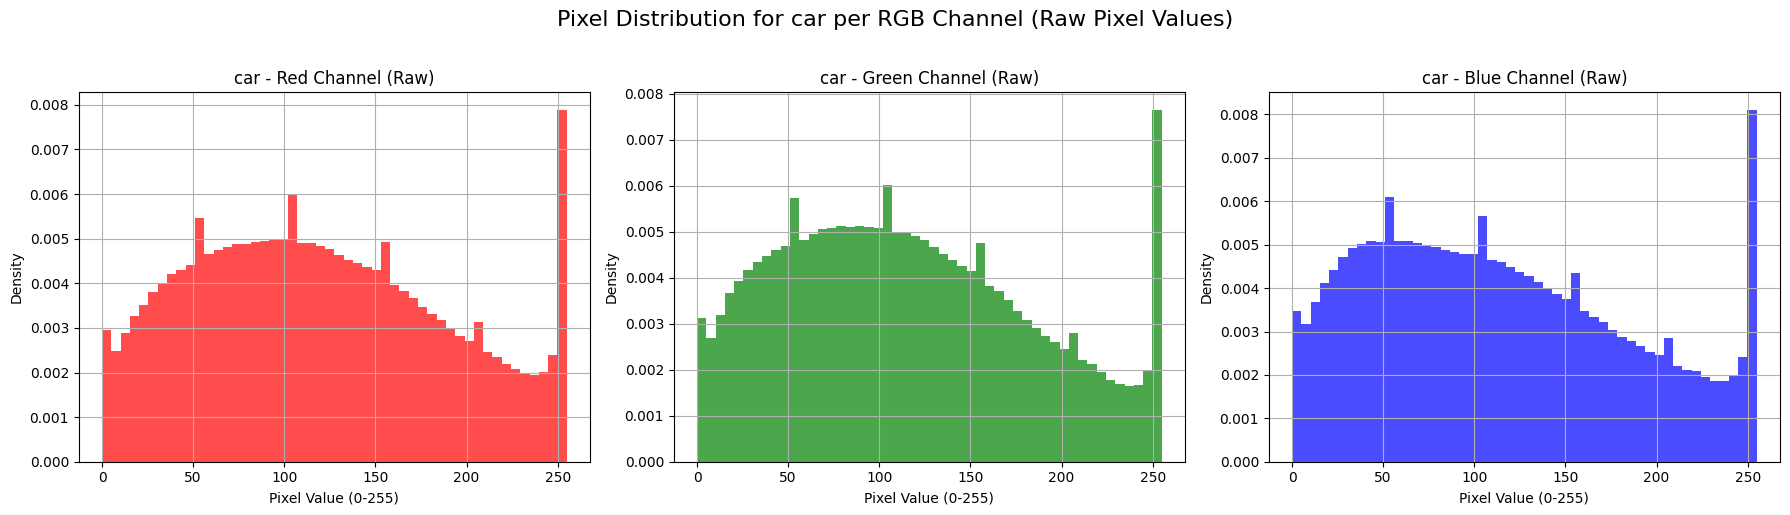

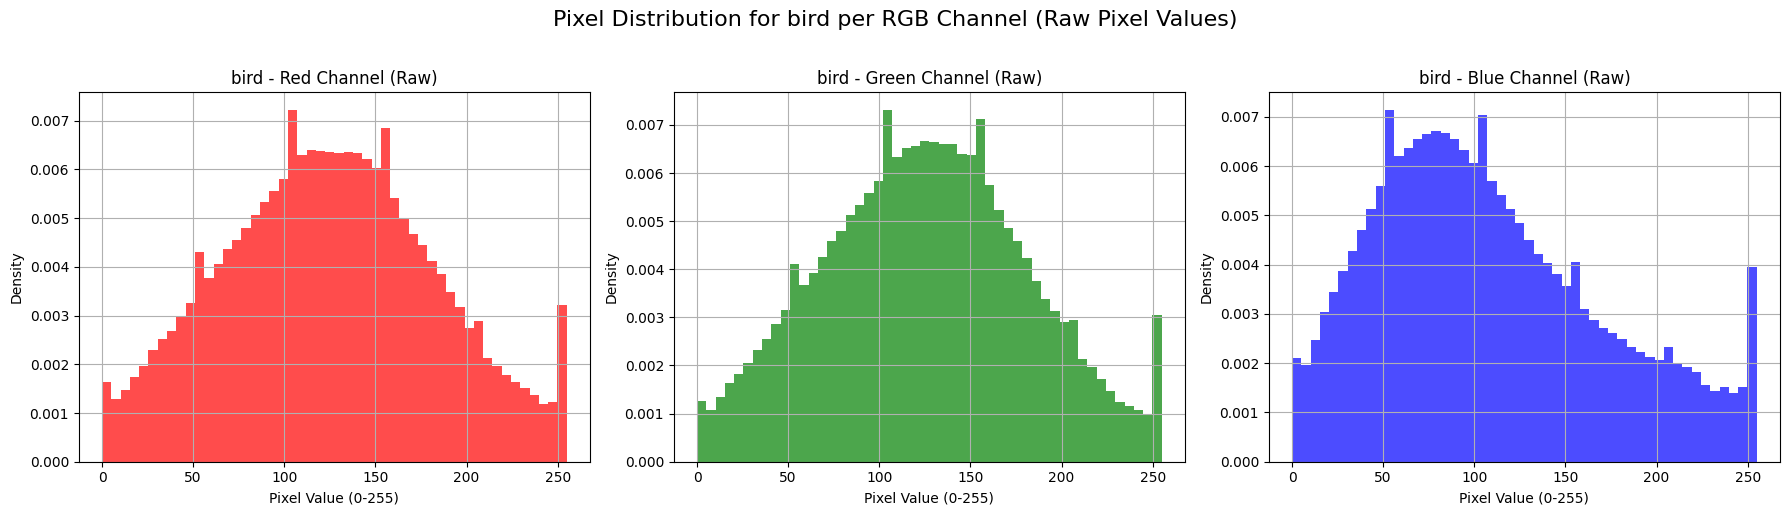

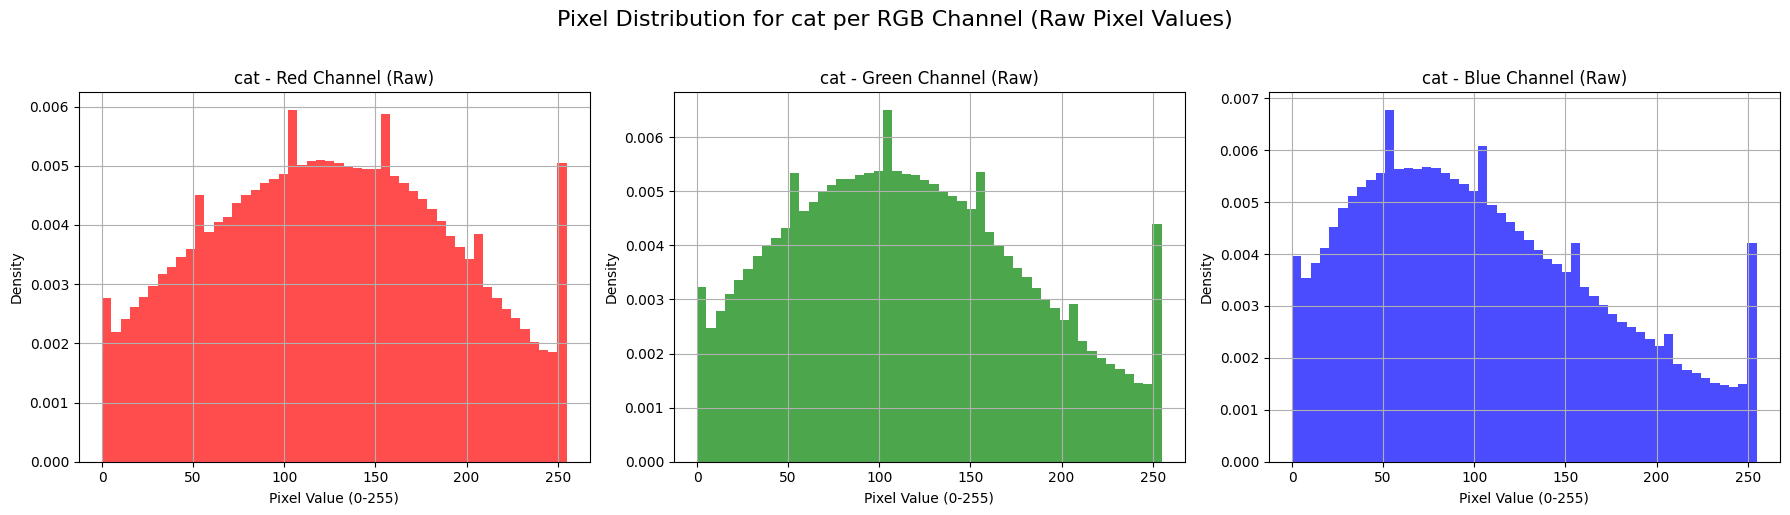

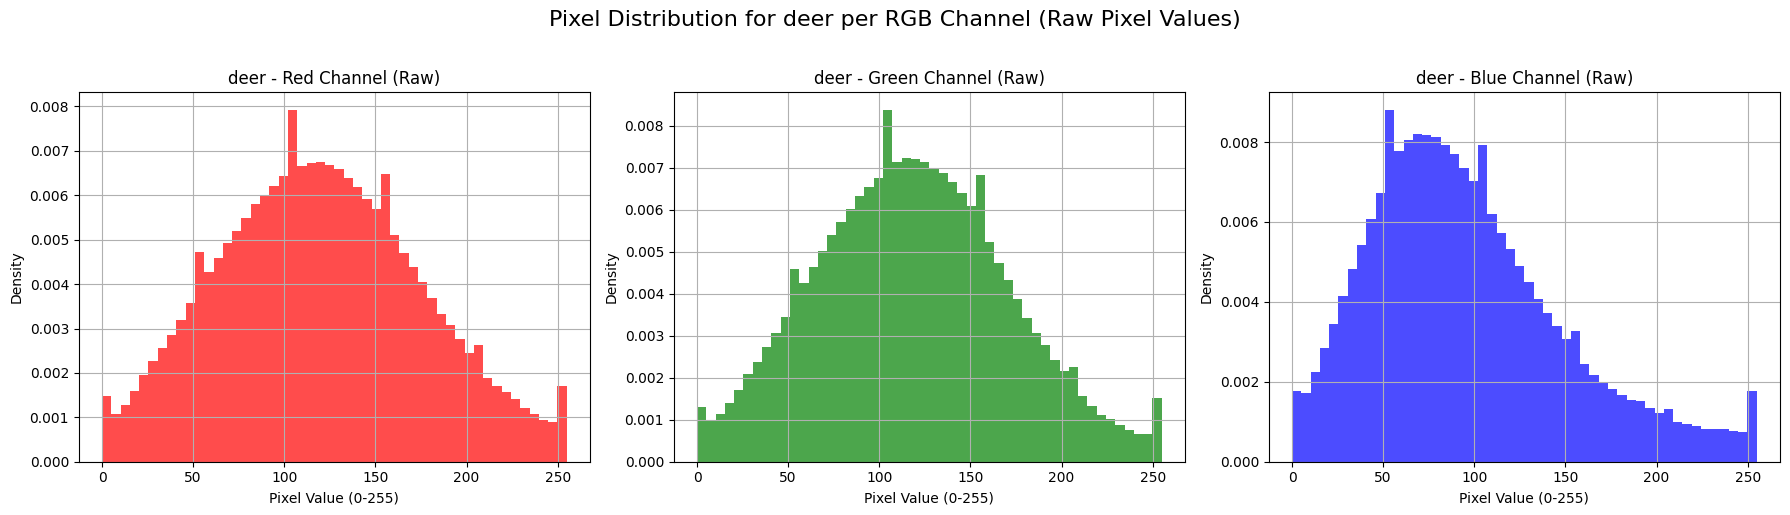

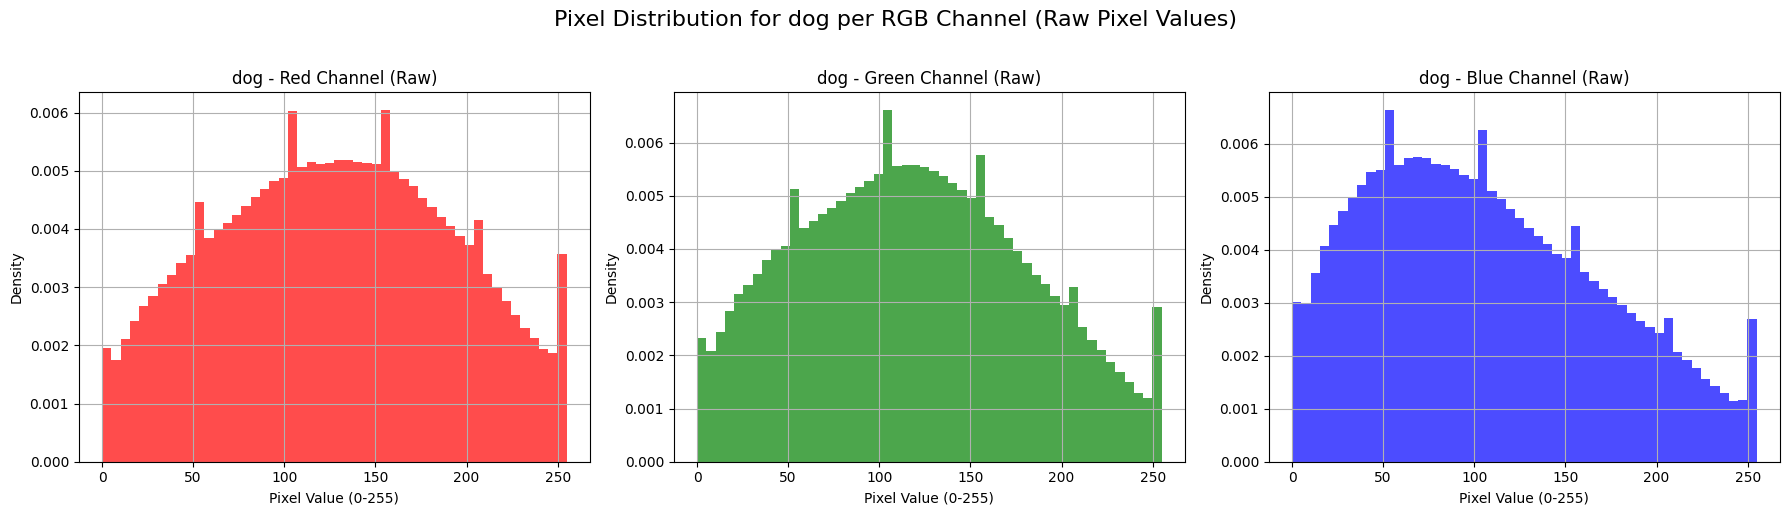

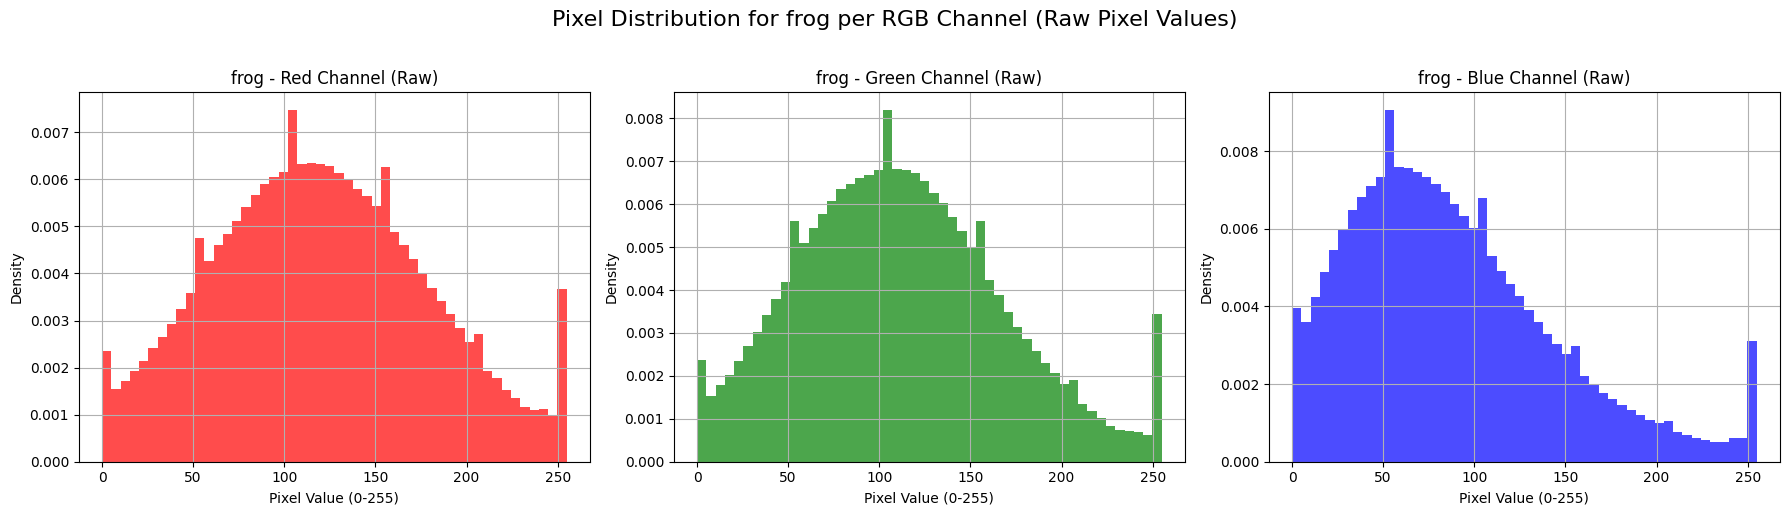

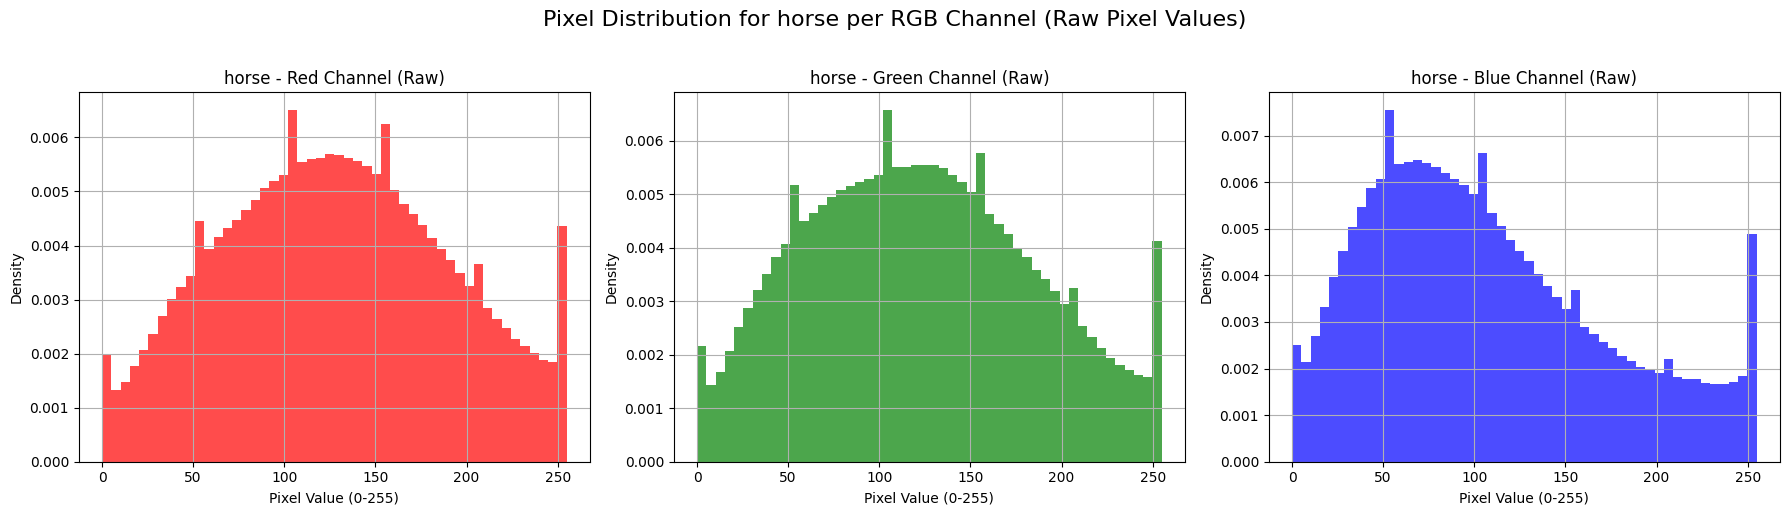

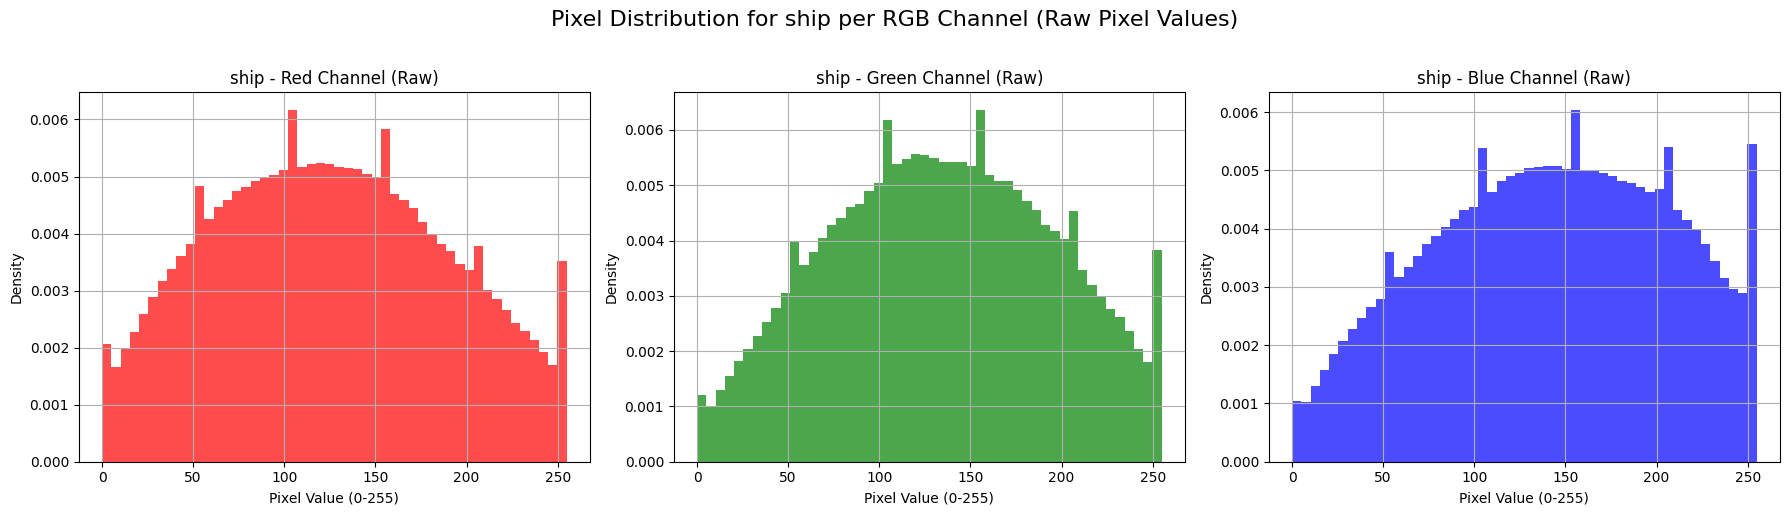

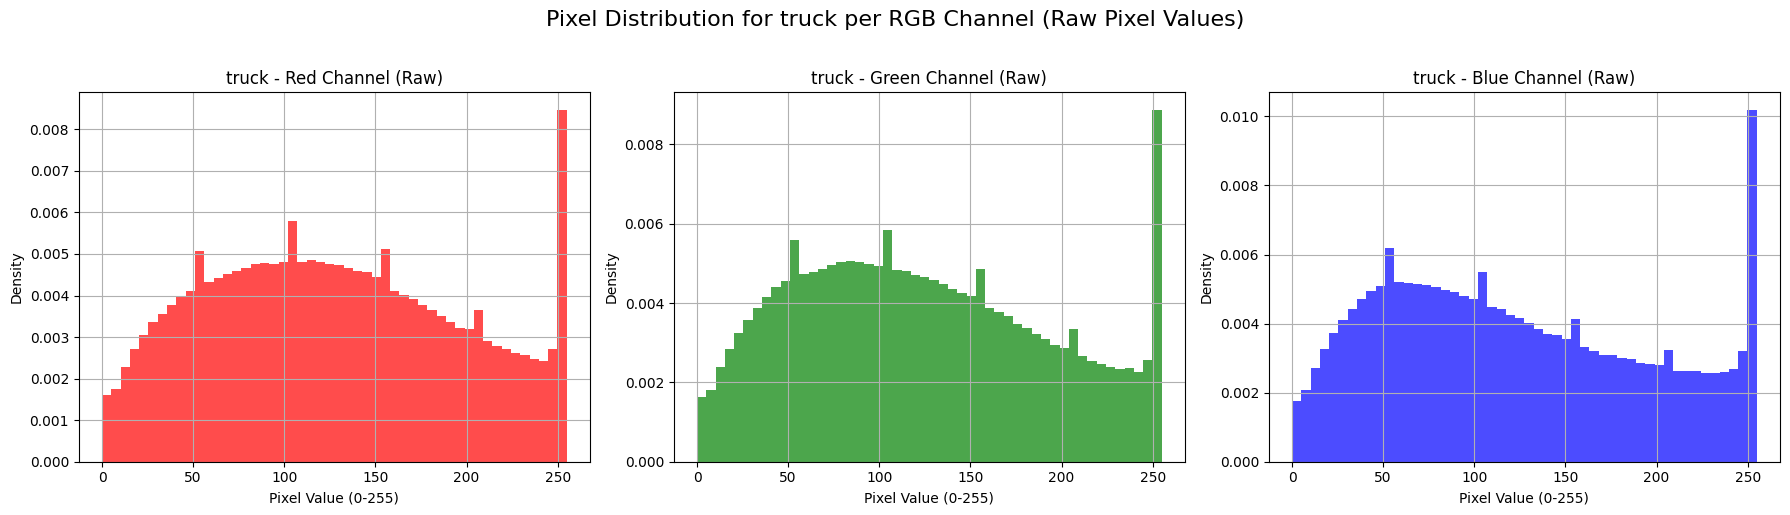

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Combine train and test datasets for overall pixel distribution analysis (without normalization)
combined_data_raw = np.concatenate((trainset.data, testset.data), axis=0)

# Flatten pixel values to [0, 255] for distribution analysis
all_pixels_raw = combined_data_raw.flatten()

# Overall pixel distribution without normalization
plt.figure(figsize=(10, 5))
plt.hist(all_pixels_raw, bins=50, density=True, color='lightgreen', alpha=0.7)
plt.title('Overall Pixel Distribution Across All Images (Raw Pixel Values)')
plt.xlabel('Pixel Value (0-255)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Overall pixel distribution for each RGB channel without normalization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['red', 'green', 'blue']
titles = ['Red Channel', 'Green Channel', 'Blue Channel']

for i in range(3):
    axes[i].hist(combined_data_raw[:, :, :, i].flatten(), bins=50, density=True, color=colors[i], alpha=0.7)
    axes[i].set_title(f'Overall Pixel Distribution - {titles[i]} (Raw)')
    axes[i].set_xlabel('Pixel Value (0-255)')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)
plt.suptitle('Overall Pixel Distribution per RGB Channel (Raw Pixel Values)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class without normalization
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, class_name in enumerate(classes):
    class_indices_train = [j for j, label in enumerate(trainset.targets) if label == i]
    class_indices_test = [j for j, label in enumerate(testset.targets) if label == i]
    
    class_data_train = trainset.data[class_indices_train]
    class_data_test = testset.data[class_indices_test]
    
    class_combined_data_raw = np.concatenate((class_data_train, class_data_test), axis=0)
    class_pixels_raw = class_combined_data_raw.flatten()
    
    axes[i].hist(class_pixels_raw, bins=50, density=True, color='lightsalmon', alpha=0.7)
    axes[i].set_title(f'Pixel Distribution for {class_name} (Raw Pixel Values)')
    axes[i].grid(True)

plt.suptitle('Pixel Distribution by Class (Raw Pixel Values)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class for each RGB channel without normalization
for i, class_name in enumerate(classes):
    class_indices_train = [j for j, label in enumerate(trainset.targets) if label == i]
    class_indices_test = [j for j, label in enumerate(testset.targets) if label == i]
    
    class_data_train = trainset.data[class_indices_train]
    class_data_test = testset.data[class_indices_test]
    
    class_combined_data_raw = np.concatenate((class_data_train, class_data_test), axis=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for c in range(3):
        axes[c].hist(class_combined_data_raw[:, :, :, c].flatten(), bins=50, density=True, color=colors[c], alpha=0.7)
        axes[c].set_title(f'{class_name} - {titles[c]} (Raw)')
        axes[c].set_xlabel('Pixel Value (0-255)')
        axes[c].set_ylabel('Density')
        axes[c].grid(True)
    plt.suptitle(f'Pixel Distribution for {class_name} per RGB Channel (Raw Pixel Values)', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


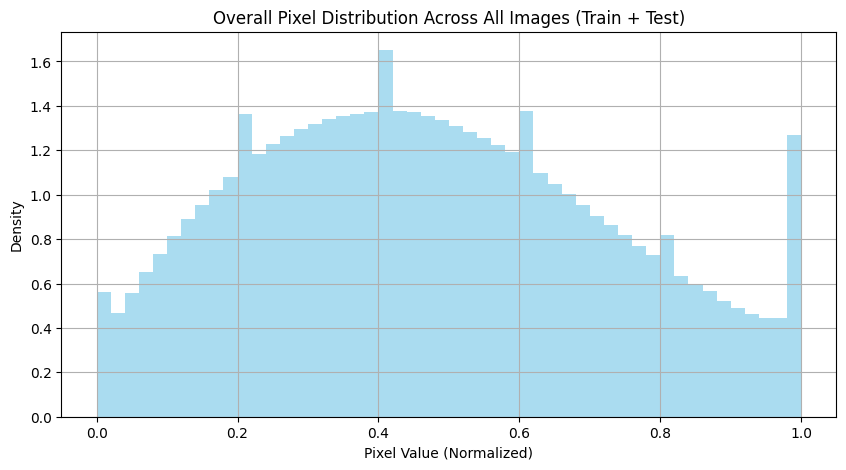

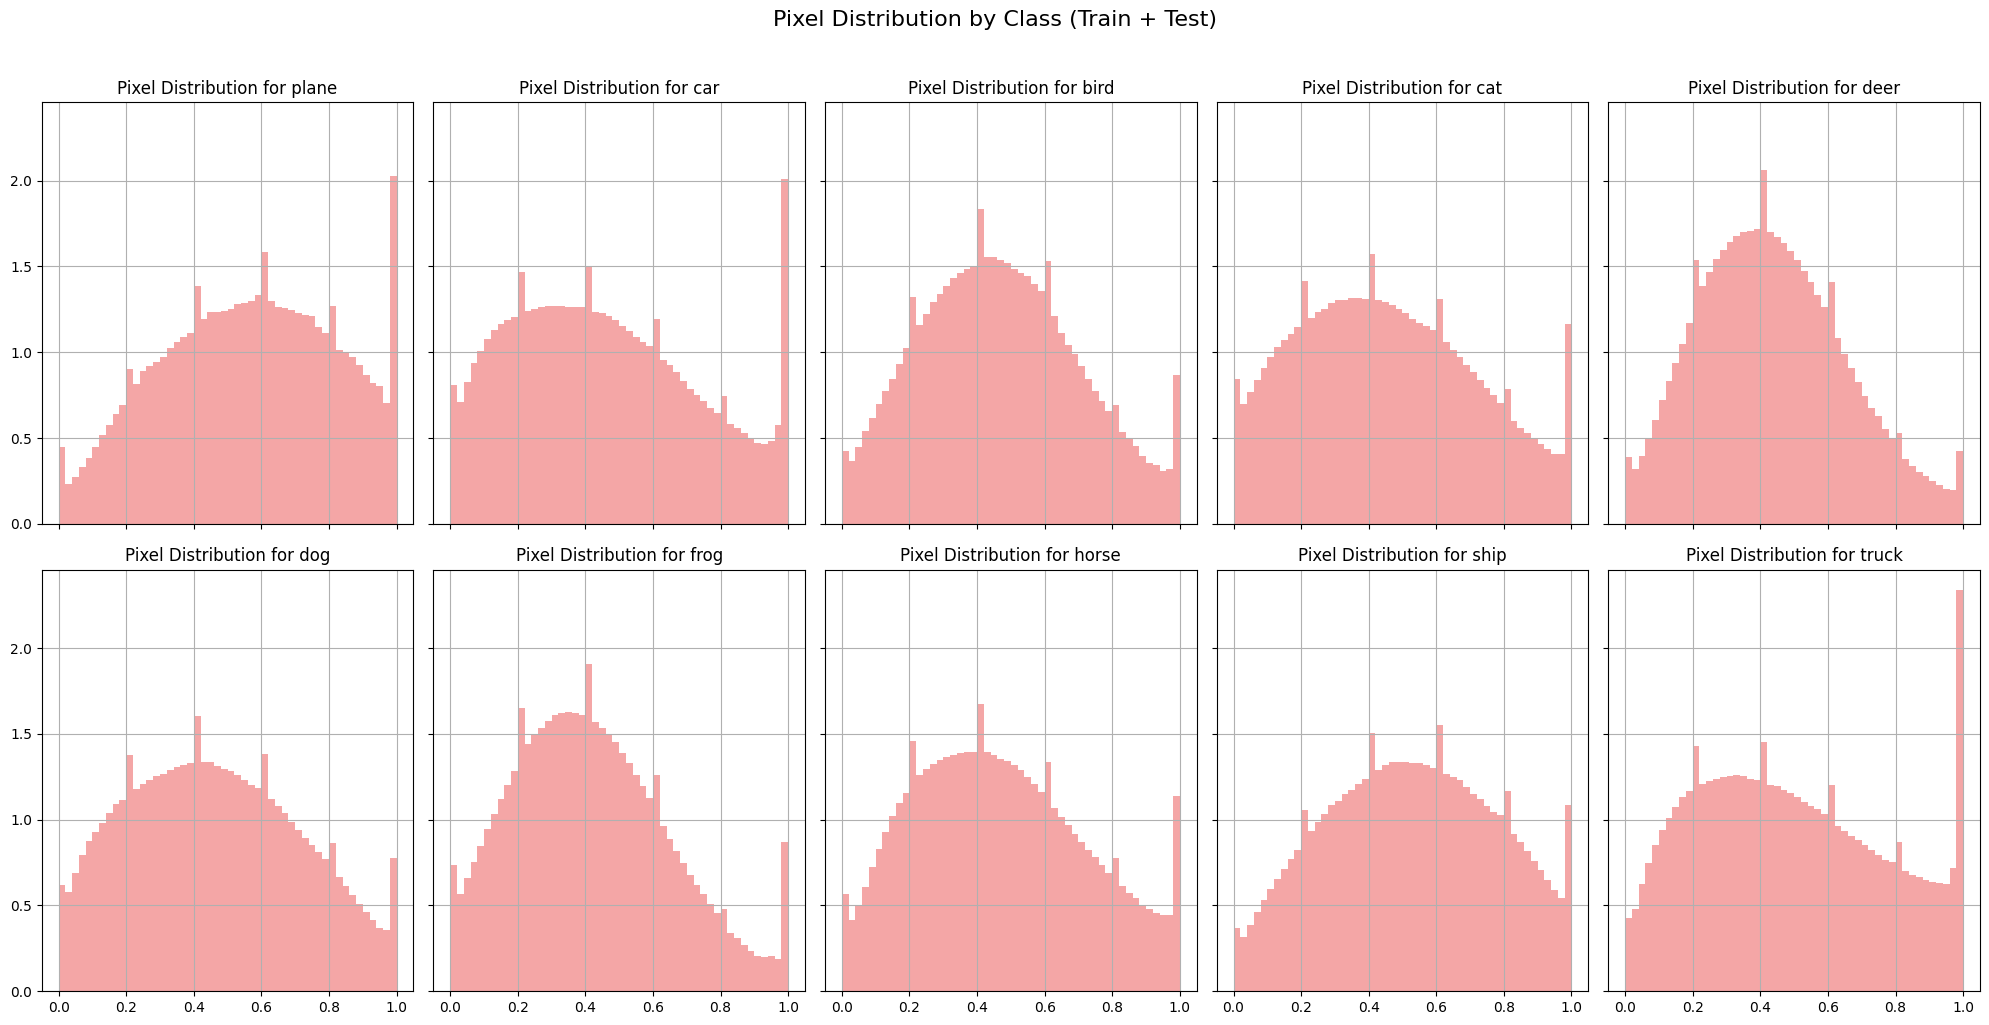

Normalization Parameters: {'mean': [0.49139967861920936, 0.48215840840079704, 0.446530914459704], 'std': [0.24703223245050313, 0.24348512800288716, 0.2615878417317208]}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Combine train and test datasets for overall pixel distribution analysis
combined_data = np.concatenate((trainset.data, testset.data), axis=0)

# Flatten and normalize pixel values to [0, 1] for distribution analysis
all_pixels = combined_data.flatten() / 255.0

# Overall pixel distribution
plt.figure(figsize=(10, 5))
plt.hist(all_pixels, bins=50, density=True, color='skyblue', alpha=0.7)
plt.title('Overall Pixel Distribution Across All Images (Train + Test)')
plt.xlabel('Pixel Value (Normalized)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Overall pixel distribution for each RGB channel (Normalized)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['red', 'green', 'blue']
titles = ['Red Channel', 'Green Channel', 'Blue Channel']

for i in range(3):
    axes[i].hist(combined_data[:, :, :, i].flatten() / 255.0, bins=50, density=True, color=colors[i], alpha=0.7)
    axes[i].set_title(f'Overall Pixel Distribution - {titles[i]} (Normalized)')
    axes[i].set_xlabel('Pixel Value (Normalized)')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)
plt.suptitle('Overall Pixel Distribution per RGB Channel (Normalized Pixel Values)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, class_name in enumerate(classes):
    class_indices_train = [j for j, label in enumerate(trainset.targets) if label == i]
    class_indices_test = [j for j, label in enumerate(testset.targets) if label == i]
    
    class_data_train = trainset.data[class_indices_train]
    class_data_test = testset.data[class_indices_test]
    
    class_combined_data = np.concatenate((class_data_train, class_data_test), axis=0)
    class_pixels = class_combined_data.flatten() / 255.0
    
    axes[i].hist(class_pixels, bins=50, density=True, color='lightcoral', alpha=0.7)
    axes[i].set_title(f'Pixel Distribution for {class_name}')
    axes[i].grid(True)

plt.suptitle('Pixel Distribution by Class (Train + Test)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class for each RGB channel (Normalized)
for i, class_name in enumerate(classes):
    class_indices_train = [j for j, label in enumerate(trainset.targets) if label == i]
    class_indices_test = [j for j, label in enumerate(testset.targets) if label == i]
    
    class_data_train = trainset.data[class_indices_train]
    class_data_test = testset.data[class_indices_test]
    
    class_combined_data = np.concatenate((class_data_train, class_data_test), axis=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for c in range(3):
        axes[c].hist(class_combined_data[:, :, :, c].flatten() / 255.0, bins=50, density=True, color=colors[c], alpha=0.7)
        axes[c].set_title(f'{class_name} - {titles[c]} (Normalized)')
        axes[c].set_xlabel('Pixel Value (Normalized)')
        axes[c].set_ylabel('Density')
        axes[c].grid(True)
    plt.suptitle(f'Pixel Distribution for {class_name} per RGB Channel (Normalized Pixel Values)', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

# Compute mean and standard deviation for normalization
# It's good practice to compute mean and std on the training data only to prevent data leakage

# Convert trainset images to float and normalize to [0, 1] for calculation
train_images = np.array([np.array(trainset.data[i]) for i in range(len(trainset))]) / 255.0

mean_per_channel = np.mean(train_images, axis=(0, 1, 2))
std_per_channel = np.std(train_images, axis=(0, 1, 2))

normalization_params = {
    'mean': mean_per_channel.tolist(),
    'std': std_per_channel.tolist()
}

print(f"Normalization Parameters: {normalization_params}")


### Post Normalization

Normalized data collection complete.


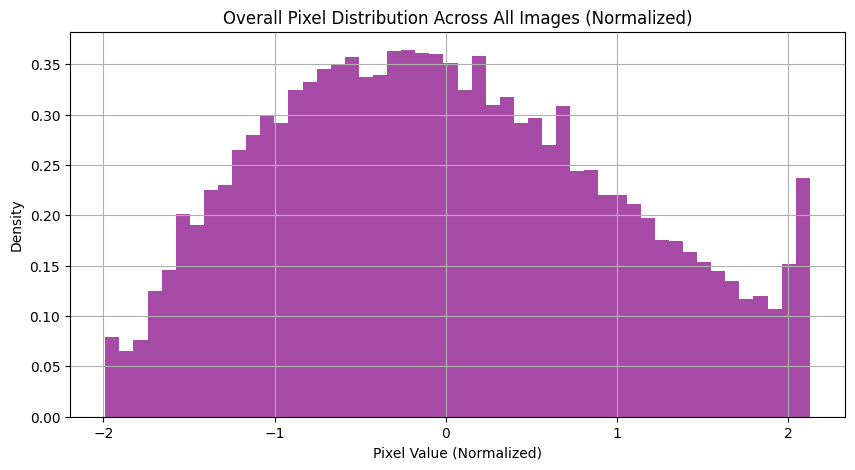

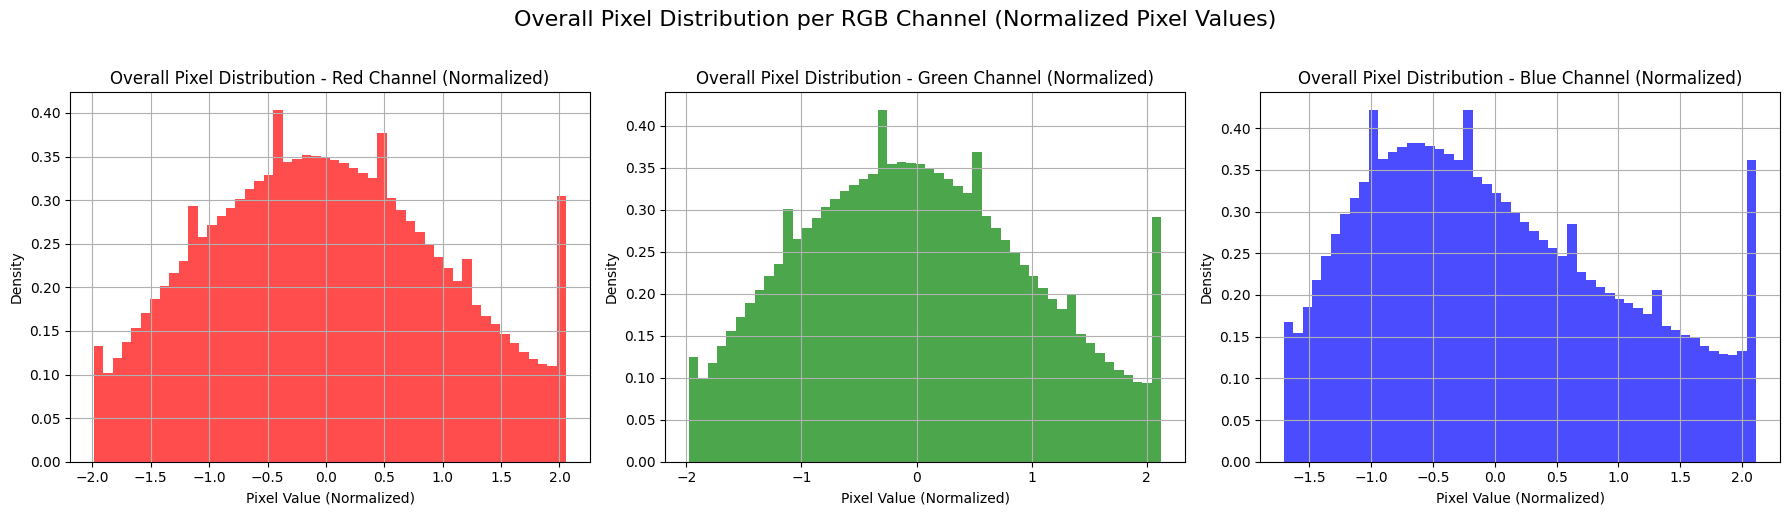

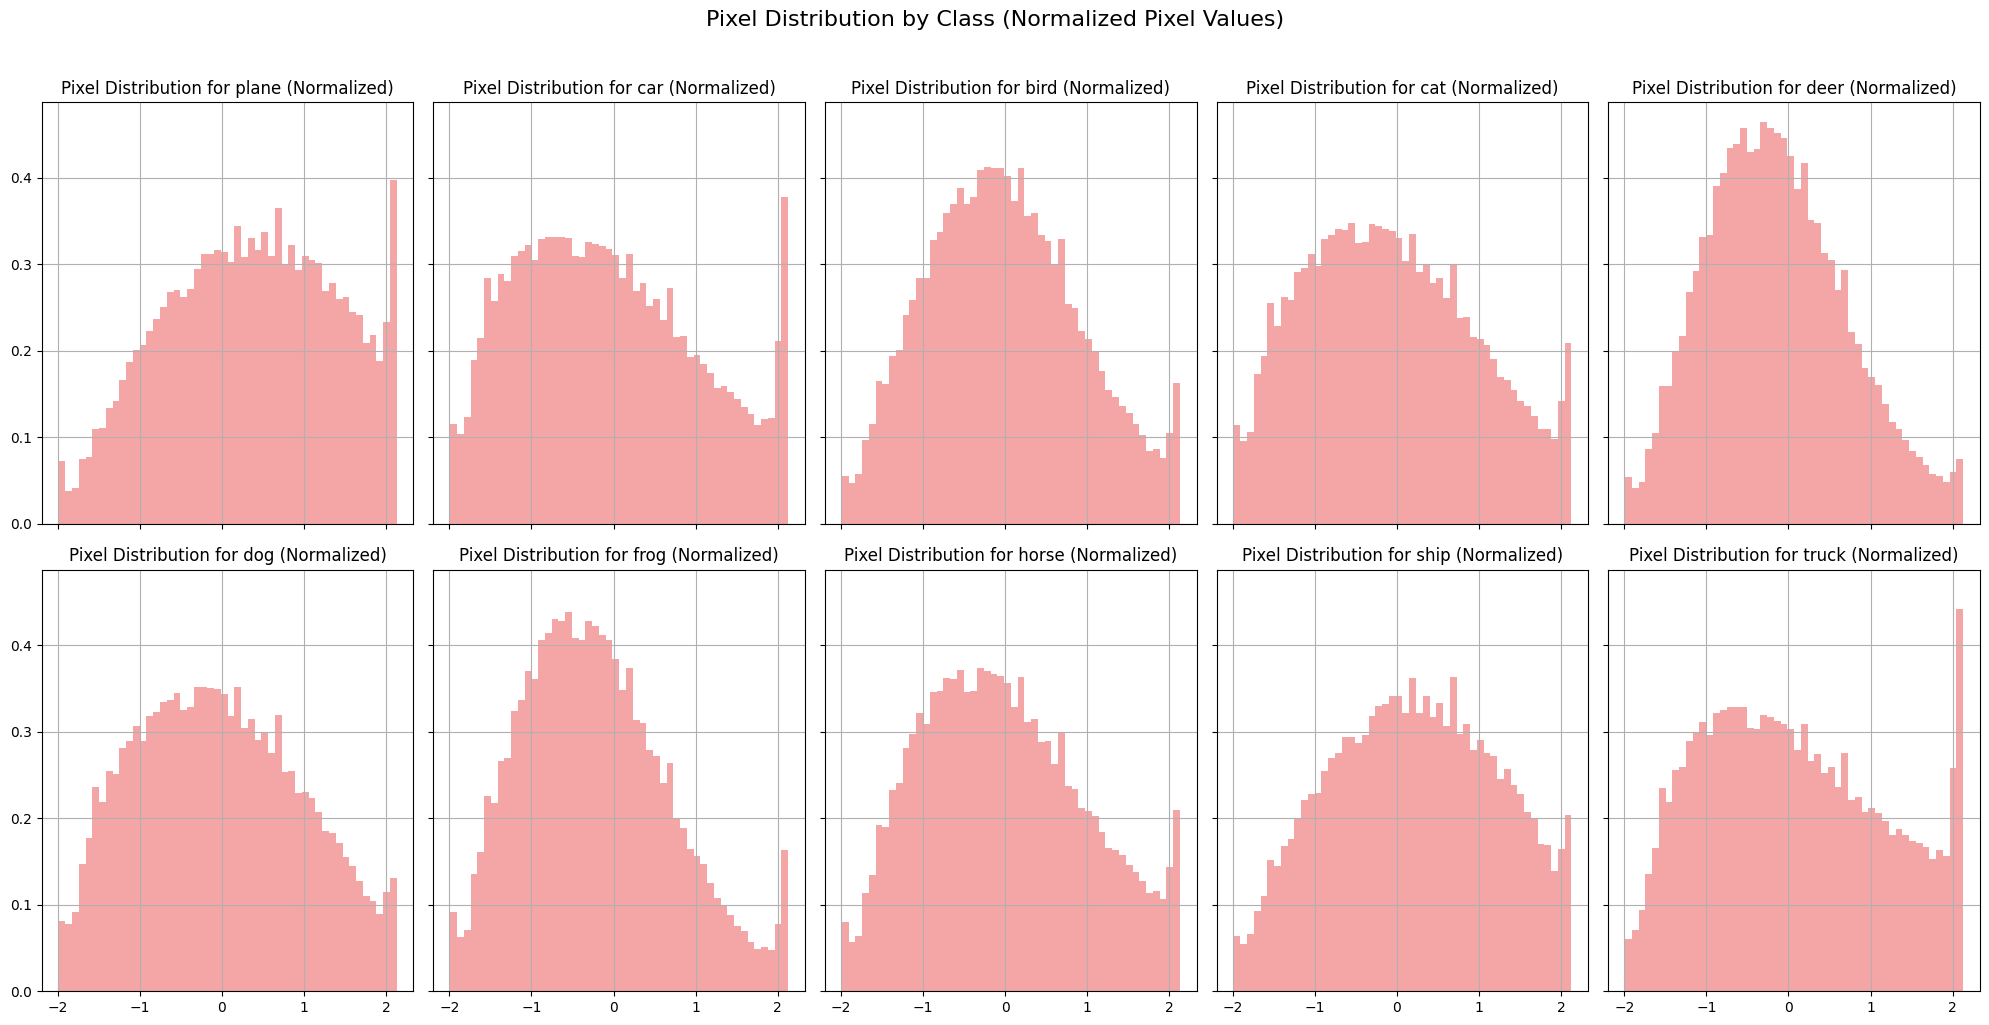

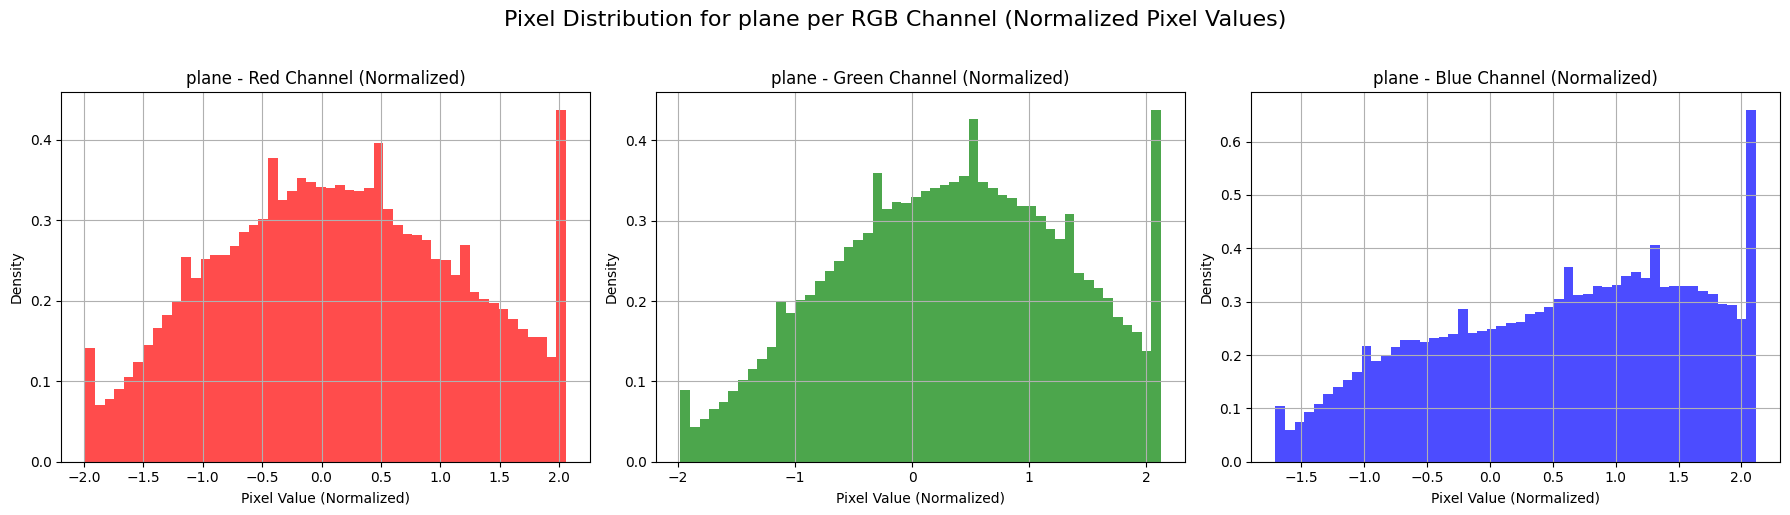

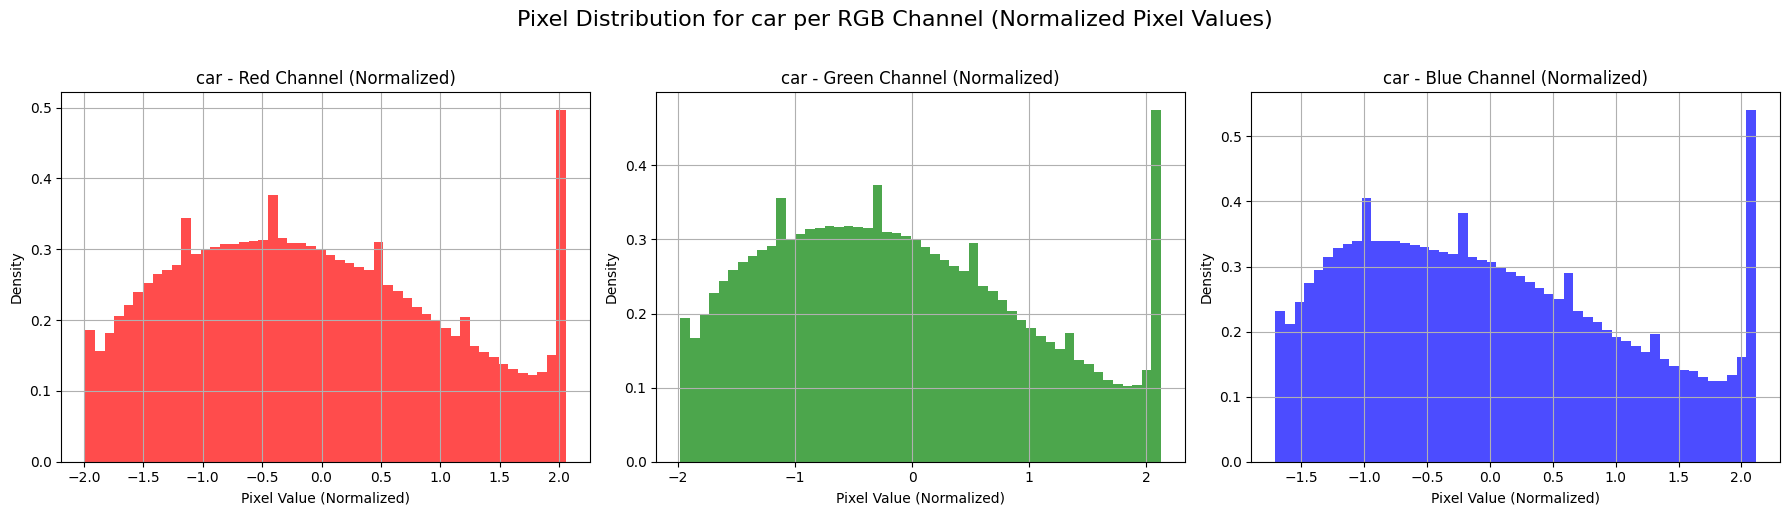

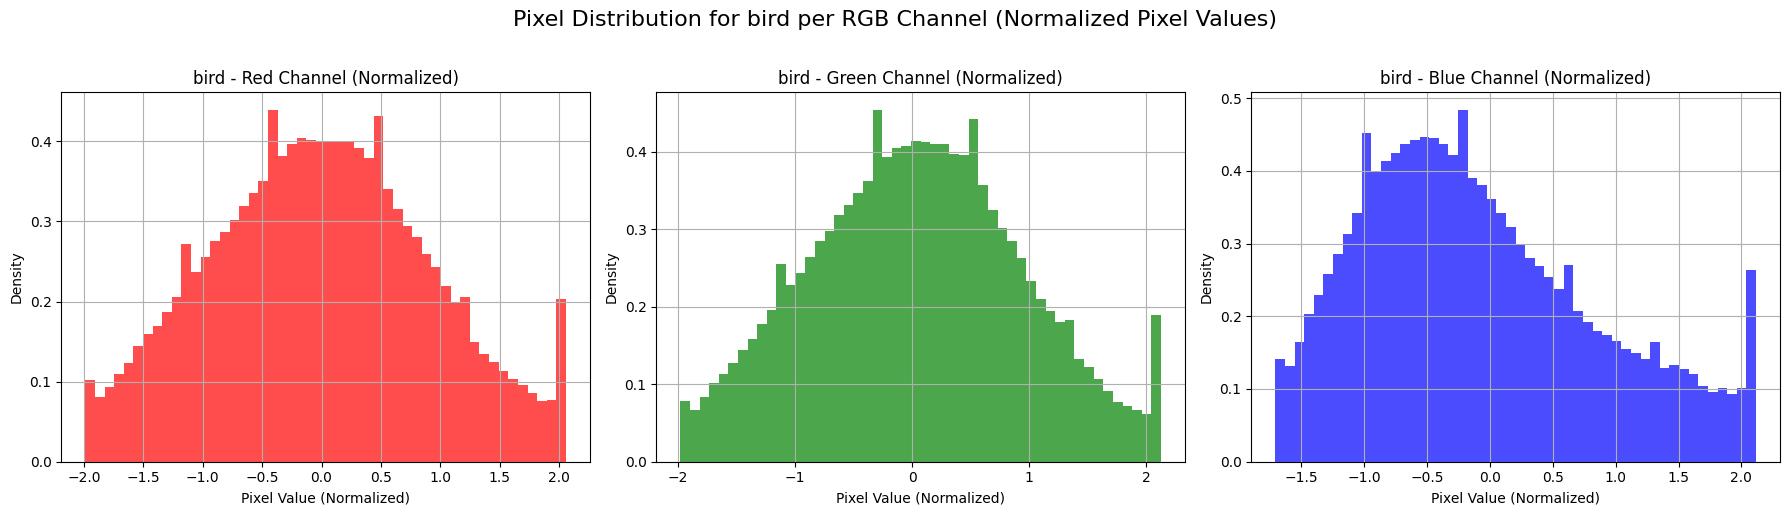

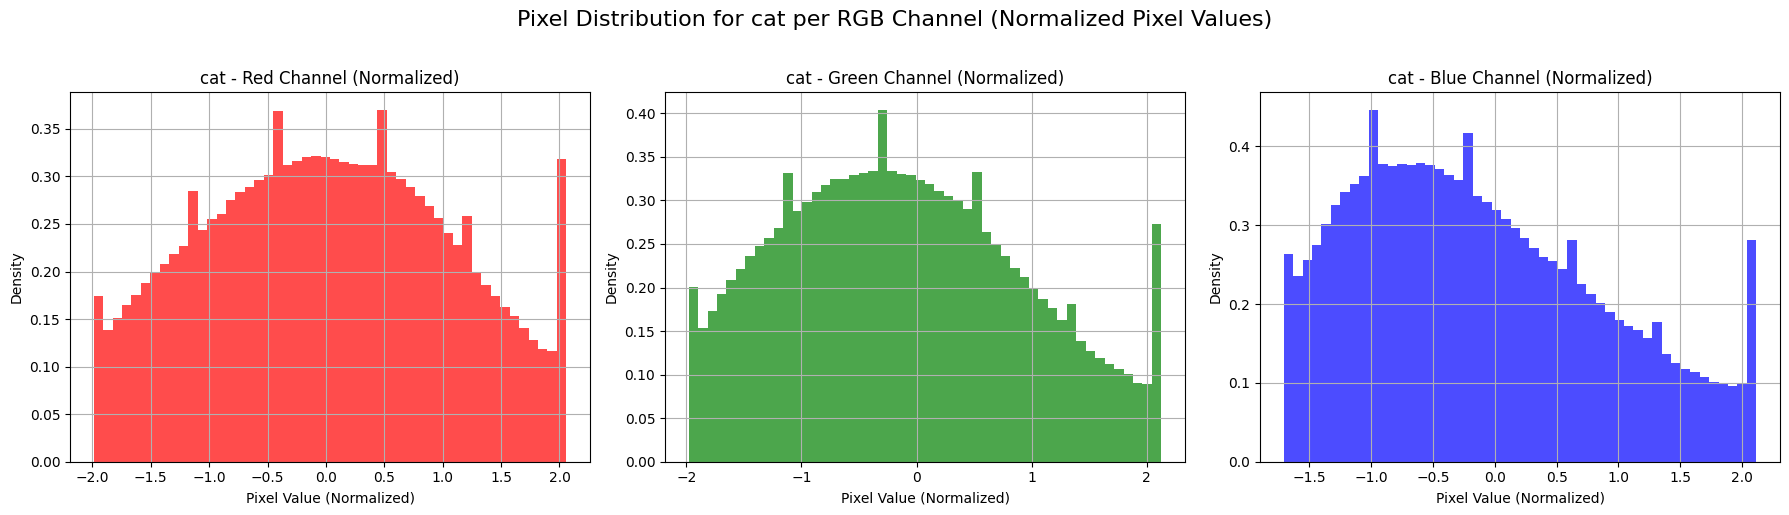

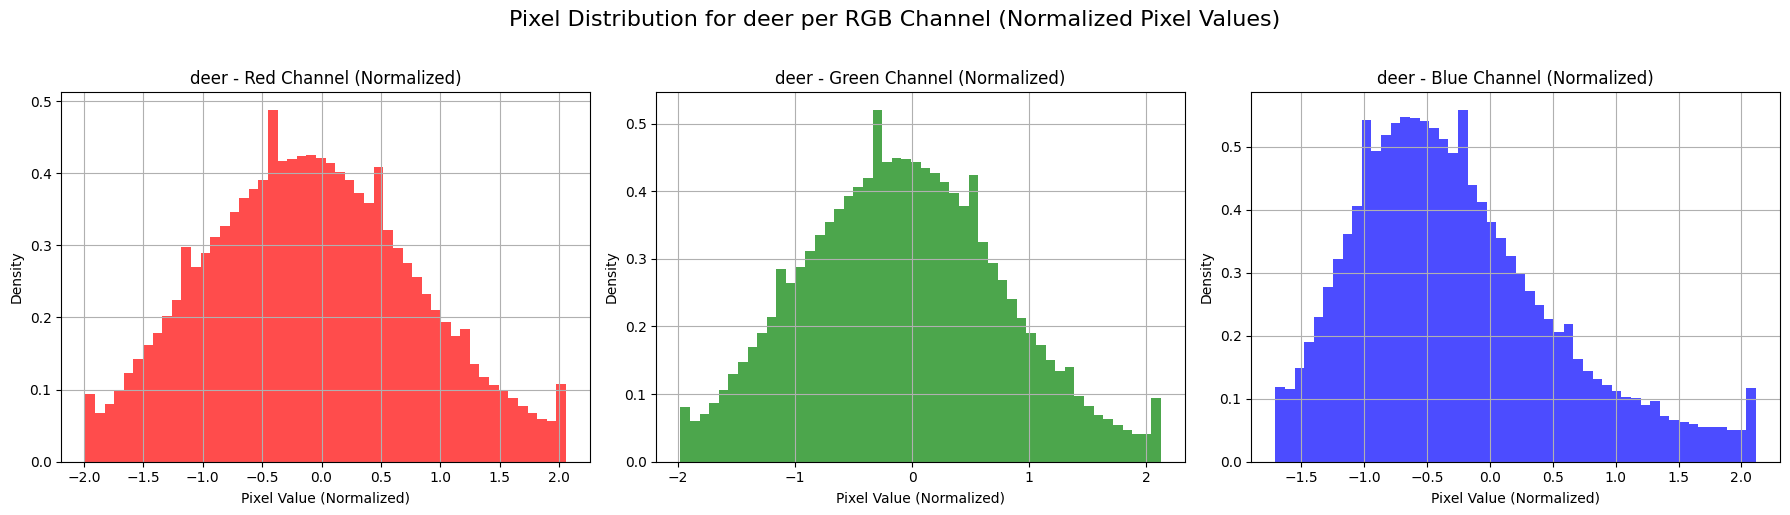

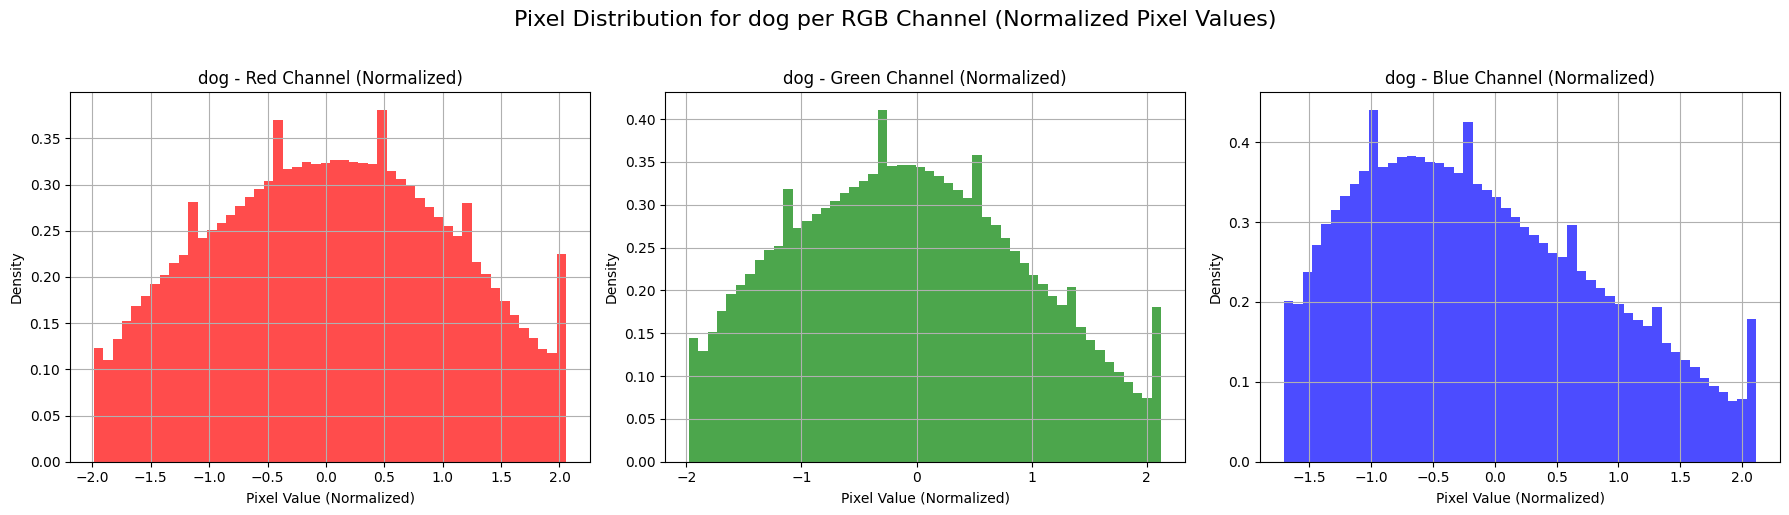

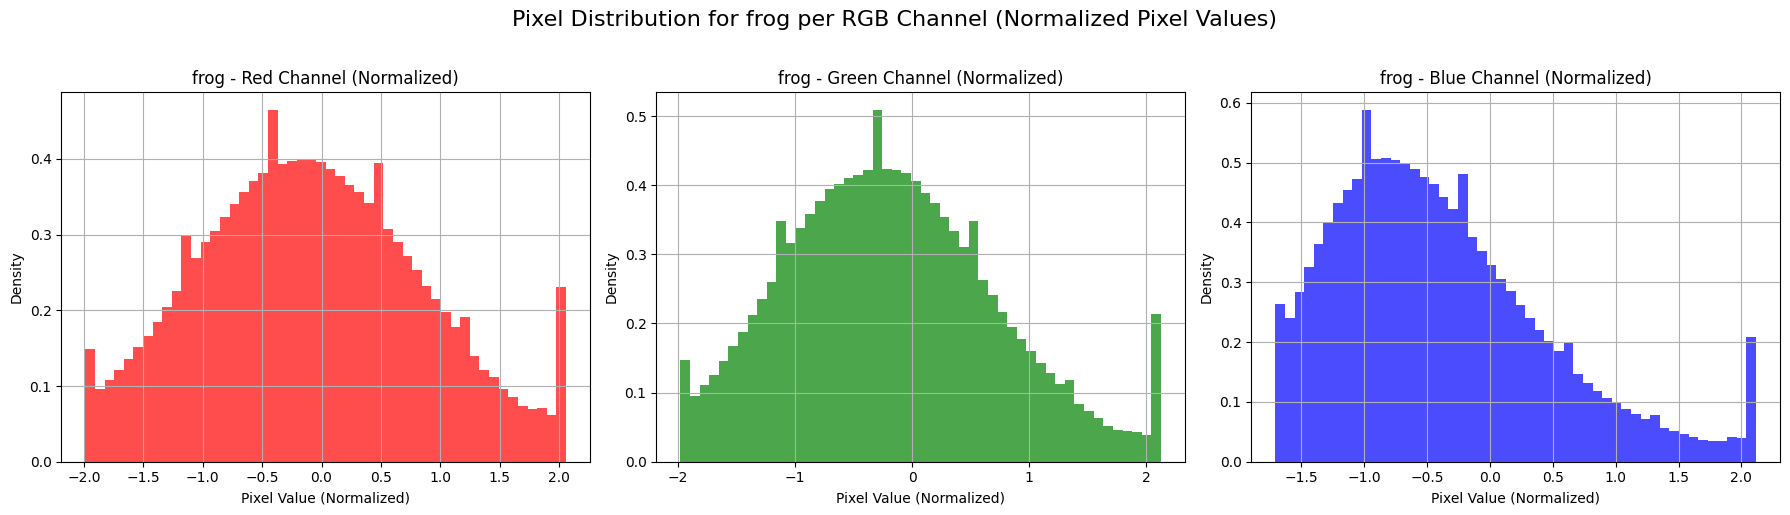

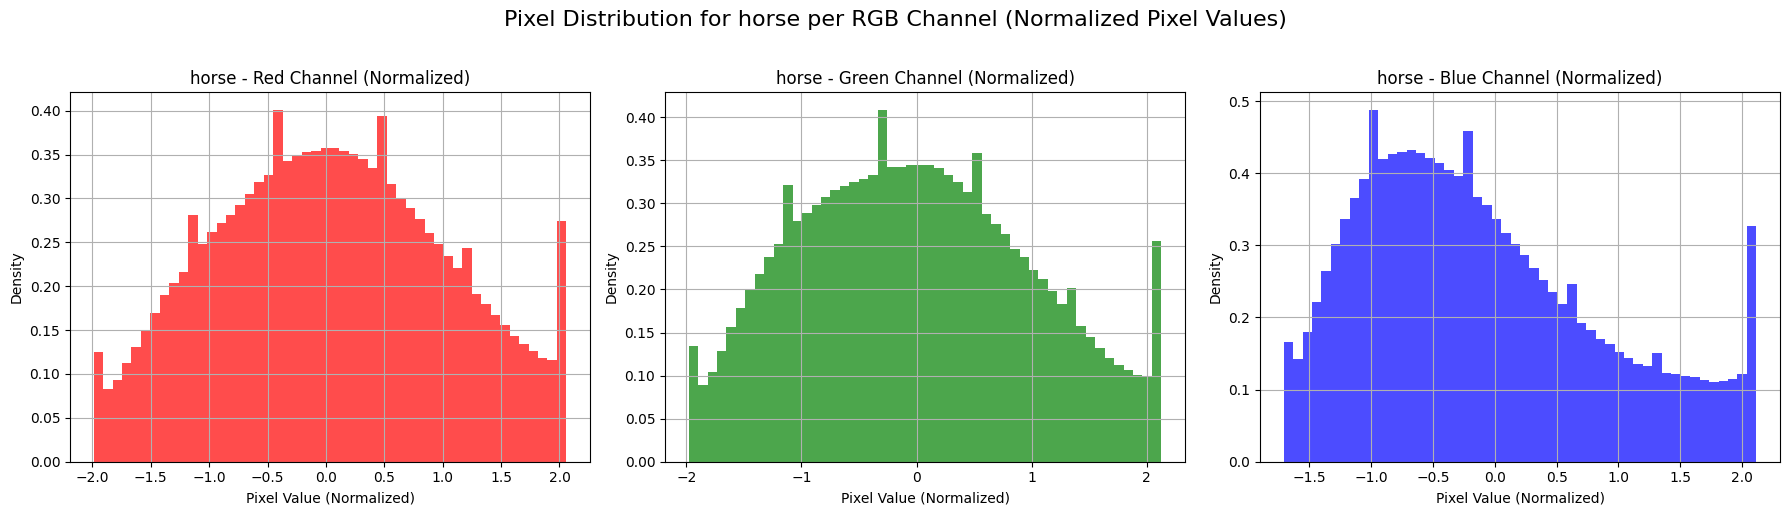

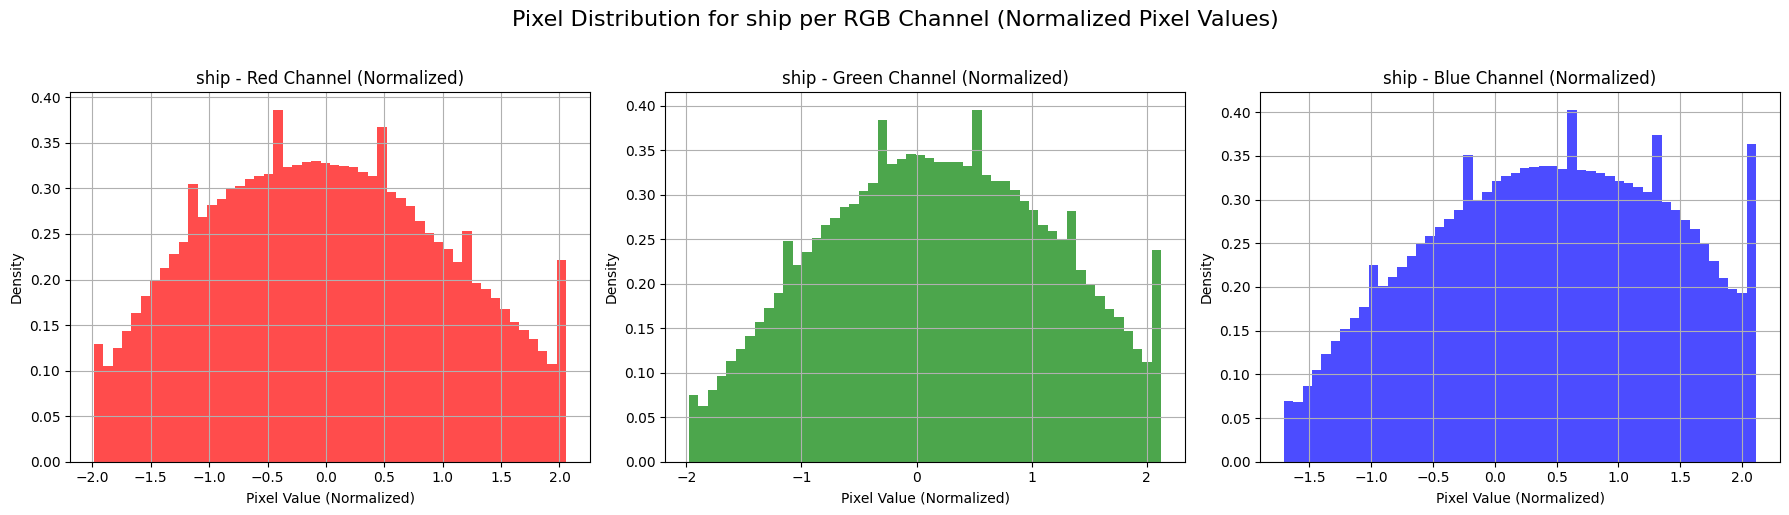

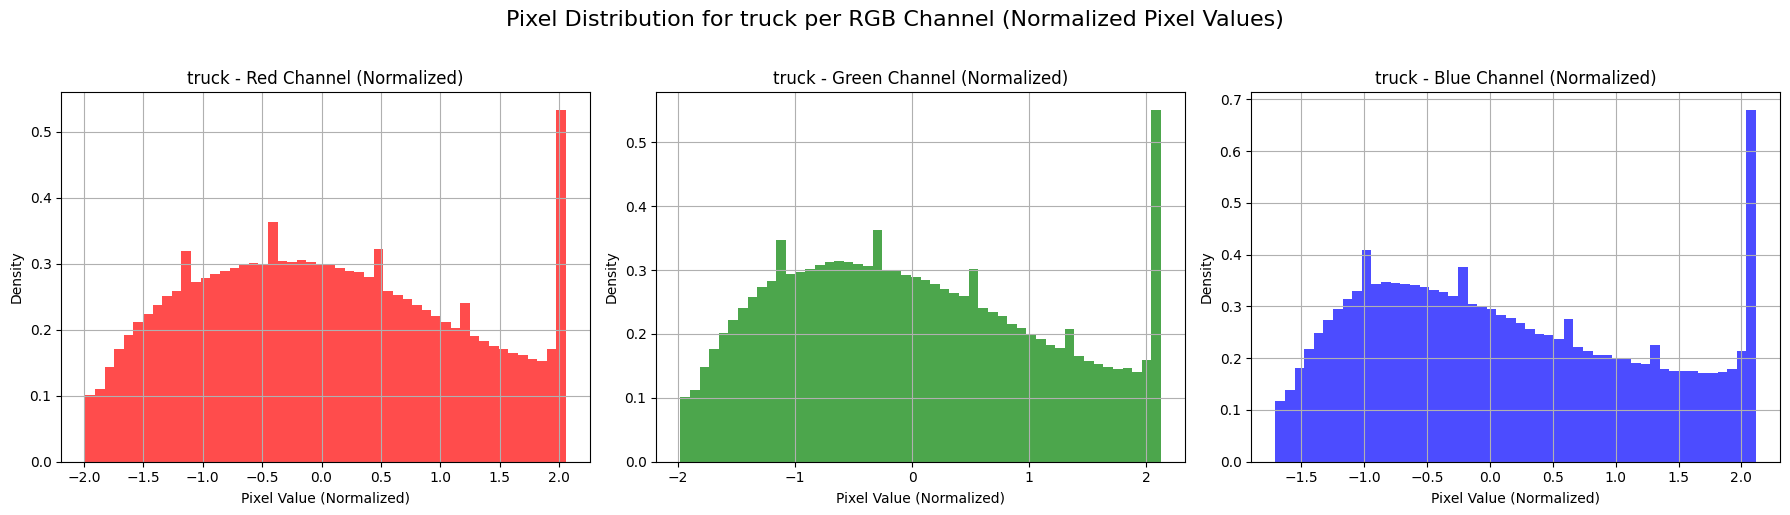

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Normalization parameters from previous analysis
mean_per_channel = [0.49139967861920936, 0.48215840840079704, 0.446530914459704]
std_per_channel = [0.24703223245050313, 0.24348512800288716, 0.2615878417317208]

transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_per_channel, std_per_channel)
])

# Create new datasets with normalization applied
trainset_normalized = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_normalized)
testset_normalized = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_normalized)

# Concatenate normalized data for overall distribution analysis
# We need to manually iterate to apply transforms and then concatenate tensors
print("Collecting normalized data for distribution analysis...")
all_normalized_images_list = []
all_normalized_labels_list = []

# Collect data from trainset_normalized
for i in range(len(trainset_normalized)):
    image, label = trainset_normalized[i]
    all_normalized_images_list.append(image)
    all_normalized_labels_list.append(label)

# Collect data from testset_normalized
for i in range(len(testset_normalized)):
    image, label = testset_normalized[i]
    all_normalized_images_list.append(image)
    all_normalized_labels_list.append(label)

all_normalized_images_tensor = torch.stack(all_normalized_images_list) # (N, C, H, W)
all_normalized_labels_tensor = torch.tensor(all_normalized_labels_list) # (N)
print("Normalized data collection complete.")

# Convert to numpy for plotting
all_pixels_normalized_np = all_normalized_images_tensor.numpy() # (N, C, H, W)

# Overall pixel distribution (all channels combined)
plt.figure(figsize=(10, 5))
plt.hist(all_pixels_normalized_np.flatten(), bins=50, density=True, color='purple', alpha=0.7)
plt.title('Overall Pixel Distribution Across All Images (Normalized)')
plt.xlabel('Pixel Value (Normalized)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Overall pixel distribution for each RGB channel (Normalized)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['red', 'green', 'blue']
titles = ['Red Channel', 'Green Channel', 'Blue Channel']

for i in range(3):
    axes[i].hist(all_pixels_normalized_np[:, i, :, :].flatten(), bins=50, density=True, color=colors[i], alpha=0.7)
    axes[i].set_title(f'Overall Pixel Distribution - {titles[i]} (Normalized)')
    axes[i].set_xlabel('Pixel Value (Normalized)')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)
plt.suptitle('Overall Pixel Distribution per RGB Channel (Normalized Pixel Values)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class (all channels combined)
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, class_name in enumerate(classes):
    class_indices = (all_normalized_labels_tensor == i).nonzero(as_tuple=True)[0]
    class_images_normalized = all_normalized_images_tensor[class_indices]
    
    axes[i].hist(class_images_normalized.numpy().flatten(), bins=50, density=True, color='lightcoral', alpha=0.7)
    axes[i].set_title(f'Pixel Distribution for {class_name} (Normalized)')
    axes[i].grid(True)

plt.suptitle('Pixel Distribution by Class (Normalized Pixel Values)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class for each RGB channel (Normalized)
for i, class_name in enumerate(classes):
    class_indices = (all_normalized_labels_tensor == i).nonzero(as_tuple=True)[0]
    class_images_normalized = all_normalized_images_tensor[class_indices].numpy() # (N_class, C, H, W)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for c in range(3):
        axes[c].hist(class_images_normalized[:, c, :, :].flatten(), bins=50, density=True, color=colors[c], alpha=0.7)
        axes[c].set_title(f'{class_name} - {titles[c]} (Normalized)')
        axes[c].set_xlabel('Pixel Value (Normalized)')
        axes[c].set_ylabel('Density')
        axes[c].grid(True)
    plt.suptitle(f'Pixel Distribution for {class_name} per RGB Channel (Normalized Pixel Values)', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


### Receptive Field Per Block
Looking at the data it looks like the receptive field per block can be 7 or at max 9 to cover most of the portion of the image. Here is preview of some portions from an image that depicts a ship. Each of the deck in the ship can be covered with a block on 9 pixels, some can be covered even with 7. To be able to achieve an RF of 5 with 3x3 and stride 1 we may need 4 convolutions per block.

#### Image (Ship Base)
![Alt text](img/ship1.png)

#### Image (Ship Deck)
![Alt text](img/ship2.png)

## Observations 📝🔍

Based on the analysis of the CIFAR-10 dataset, here are some key observations:

*   **Image Resolution & Sharpness**: The image resolution of the dataset is quite low, often appearing pixelated and blurry. From the Laplacian Variance analysis, images with a sharpness index above ~500 generally seem acceptable, so no global sharpening will be applied as part of preprocessing. 📸📉 (low resolution) -> 📈 (above 500 sharpness)
*   **Partial Objects**: Some images contain only a portion of the object, yet our model needs to accurately recognize them. This highlights the importance of effective padding strategies during model training to ensure all relevant contextual information is captured. 🖼️✂️
*   **Class Distribution**: Both the training and test datasets exhibit an even distribution of labels across all classes, eliminating the need for class balancing techniques. ✅⚖️
*   **Image Characteristics**: The dataset consists of 32x32 pixel images with 3 color channels (RGB). This signifies that we are dealing with color images, presenting a higher level of complexity compared to simpler grayscale datasets like MNIST. 🎨📏
*   **Pixel Distribution**: Unlike MNIST, where pixel values tend to be concentrated in a narrower range, CIFAR-10 exhibits a broader distribution of pixel values across the full 0-255 range. This implies greater variability in brightness and color intensity within the images. 📊🔆
*   **Dataset Size**: The training set comprises 50,000 images, and the test set contains 10,000 images. These sizes are comparable to the MNIST dataset. 🔢💾
* **Normalization Parameters**: 
```{'mean': [0.49139967861920936, 0.48215840840079704, 0.446530914459704], 'std': [0.24703223245050313, 0.24348512800288716, 0.2615878417317208]}```

### Training Setup

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Data loading with basic normalization only (no augmentation)
def load_cifar10_data():
    # Basic transformation - only normalization
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Create data loaders
    train_dataset = torchvision.datasets.CIFAR10(
        root="./tdata", train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root="./tdata", train=False, download=True, transform=transform_test
    )
    trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
    
    return trainloader, testloader

# Training function
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 99:
            print(f'Batch [{batch_idx+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
    
    train_acc = 100. * correct / total
    return train_acc

# Validation function
def validate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_acc = 100. * correct / total
    avg_loss = test_loss / len(testloader)
    
    return test_acc, avg_loss

# Count model parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Plot training progress
def plot_training_progress(train_accuracies, val_accuracies, train_losses, val_losses):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_accuracies) + 1)
    
    # Accuracy plot
    ax1.plot(epochs, train_accuracies, 'b-o', label='Training Accuracy')
    ax1.plot(epochs, val_accuracies, 'r-o', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)
    
    # Loss plot
    ax2.plot(epochs, train_losses, 'b-o', label='Training Loss')
    ax2.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Main training loop
def main(model):
    print("="*60)
    print("BASELINE CNN FOR CIFAR-10")
    print("="*60)
    
    # Load data
    print("Loading CIFAR-10 dataset...")
    trainloader, testloader = load_cifar10_data()
    
    print(f"Training samples: {len(trainloader.dataset)}")
    print(f"Test samples: {len(testloader.dataset)}")
    
    
    # Count parameters
    total_params, trainable_params = count_parameters(model)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Print model architecture
    print("\nModel Architecture:")
    print(model)
    
    # Loss function and optimizer (simple Adam, no scheduler)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\nOptimizer: Adam (lr=0.001)")
    print(f"Loss function: CrossEntropyLoss")
    print(f"Training epochs: 10")
    
    # Training history
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    
    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)
    
    # Training loop for 10 epochs
    for epoch in range(10):
        start_time = time.time()
        
        print(f"\nEpoch [{epoch+1}/10]")
        print("-" * 40)
        
        # Train for one epoch
        train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        
        # Validate
        val_acc, val_loss = validate(model, testloader, criterion, device)
        
        # Calculate approximate training loss for plotting
        model.eval()
        train_loss = 0.0
        with torch.no_grad():
            for inputs, targets in trainloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                train_loss += criterion(outputs, targets).item()
        train_loss /= len(trainloader)
        
        # Store metrics
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Print epoch results
        epoch_time = time.time() - start_time
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Validation Accuracy: {val_acc:.2f}%")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Time: {epoch_time:.1f}s")
    
    # Final results
    print("\n" + "="*60)
    print("TRAINING COMPLETED")
    print("="*60)
    
    best_val_acc = max(val_accuracies)
    best_epoch = val_accuracies.index(best_val_acc) + 1
    final_val_acc = val_accuracies[-1]
    
    print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
    print(f"Total Parameters: {total_params:,}")
    
    # Plot training progress
    print("\nGenerating training plots...")
    plot_training_progress(train_accuracies, val_accuracies, train_losses, val_losses)
    
    # Test on individual classes
    print("\nPer-class accuracy:")
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    model.eval()
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    for i in range(10):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{cifar10_classes[i]}: {accuracy:.1f}%')
    
    print(f"\nBaseline model performance summary:")
    print(f"• Architecture: 4-block CNN (ResNet-inspired)")
    print(f"• No data augmentation")
    print(f"• No max pooling (used stride and global avg pooling)")
    print(f"• Simple Adam optimizer (no scheduler)")
    print(f"• Final accuracy: {final_val_acc:.2f}%")
    print(f"• Parameters: {total_params:,}")
    
    return model, train_accuracies, val_accuracies


Using device: cpu


## Basic Model

### Define Model Architecture 🏗️

In this section, we will define a basic Convolutional Neural Network (CNN) architecture. This initial model will serve as our baseline for performance evaluation on the CIFAR-10 dataset. The architecture will include:

* Convolutional layers with appropriate filters and activation functions.
* Basic Transformation (Normalization)
* No Augmentation
* No Max Pooling
* Simple Adam Optimizer with nor scheduler
* A training loop for 10 epochs 
* Evalaute accuracy at the end of each epoch using validation data
* Simple 4 convolution blocks inspired by Resnet

We will ensure the model adheres to any specified constraints (e.g., total number of parameters).

If required we will add this code later
```    
    # Initialize weights
         self._initialize_weights()
    
     def _initialize_weights(self):
         for m in self.modules():
             if isinstance(m, nn.Conv2d):
                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
             elif isinstance(m, nn.BatchNorm2d):
                 nn.init.constant_(m.weight, 1)
                 nn.init.constant_(m.bias, 0)
             elif isinstance(m, nn.Linear):
                 nn.init.normal_(m.weight, 0, 0.01)
                 nn.init.constant_(m.bias, 0)
```

In [49]:
# Basic CNN Block with receptive field = 11
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # To achieve receptive field of 11, we use multiple conv layers
        # Receptive field calculation: RF = 1 + (k1-1) + (k2-1) + (k3-1) + (k4-1)
        # Using 4 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 = 9
        # Using 3 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 = 7  
        # Using 5 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 + 2 = 11 ✓
        
        # First conv layer (with potential stride for downsampling)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Third conv layer
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        # Fourth conv layer
        self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(out_channels)
        
        # Fifth conv layer to achieve RF=11
        self.conv5 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        # Pass through all 5 conv layers for RF=11
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        out = F.relu(self.bn4(self.conv4(out)))
        out = F.relu(self.bn5(self.conv5(out)))
        
        return out

# Baseline CNN Architecture
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaselineCNN, self).__init__()
        
        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 4 Basic blocks (inspired by ResNet)
        self.block1 = BasicBlock(64, 64, stride=1)    # 32x32 -> 32x32
        self.block2 = BasicBlock(64, 128, stride=2)   # 32x32 -> 16x16
        self.block3 = BasicBlock(128, 256, stride=2)  # 16x16 -> 8x8
        self.block4 = BasicBlock(256, 512, stride=2)  # 8x8 -> 4x4
        
        # Global Average Pooling (instead of max pooling)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final classifier
        self.fc = nn.Linear(512, num_classes)
        
    
    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Pass through 4 basic blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Final classification
        x = self.fc(x)
        
        return x



Initializing baseline CNN...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...


100.0%


Training samples: 50000
Test samples: 10000
Total parameters: 14,135,498
Trainable parameters: 14,135,498

Model Architecture:
BaselineCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d

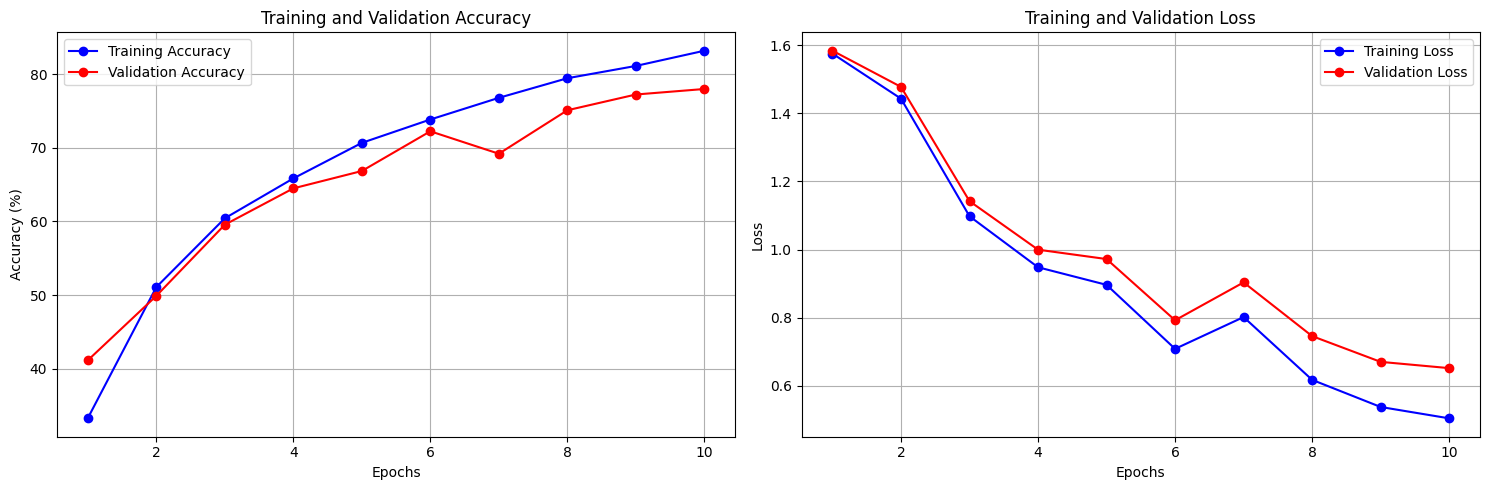


Per-class accuracy:
airplane: 72.8%
automobile: 94.9%
bird: 65.6%
cat: 62.5%
deer: 82.0%
dog: 83.4%
frog: 57.0%
horse: 84.6%
ship: 89.7%
truck: 87.6%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 78.01%
• Parameters: 14,135,498


In [50]:
# Initialize model
print("\nInitializing baseline CNN...")
model = BaselineCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model)

### Observations
From the results some of the things are very obvious 
- There is overfitting happening in the model as train accuracy is higher than the validation. This mean we need to make the model learn on ADDITIONAL DATA or make training harder with DROPOUT or both. 
- Even with ~14M parameter in the basic model, we are not able to reach the accuracy of 80% in the validation data. This means we have our work cut out 1) to reach the accuracy of 85% first and then 2) trim down the model to under 200k
- Based on the analysis of the image it looks like the Receptive Field of 9 at max or even 7 for most part should be good enough to identify the constintuents of the image. As such we can explore a smaller block of 3 or 4 convolutions with stride 1 or increase the stride to further adjust the convolutions required.

Have Fun!